# importing the important libraries

In [8]:
import wandb
wandb.login()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma23m020 (snehalma23m020-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
2025-03-16 16:28:24.000260: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 16:28:24.000756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 16:28:24.003345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 16:28:24.012648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for p

# Question 1 : Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

# Step 1 : Load the dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 

# Step 2 : The class labels

In [4]:
LABEL_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Step 3 : To visualize one sample from each category

In [10]:
def display_unique_samples(images, labels, category_names): 
    seen_classes = set()
    plt.figure(figsize=(15, 12))
    sample_count = 0

    for idx in range(len(images)):
        category = labels[idx]
        if category not in seen_classes:
            seen_classes.add(category)
            sample_count += 1
            plt.subplot(5, 2, sample_count) # subplot
            plt.imshow(images[idx], cmap='CMRmap') 
            plt.title(category_names[category])
            plt.axis("off")

            if sample_count == 10:  # all 10 categories
                break

    plt.tight_layout()
    plt.show()

# Step 4 : Display images

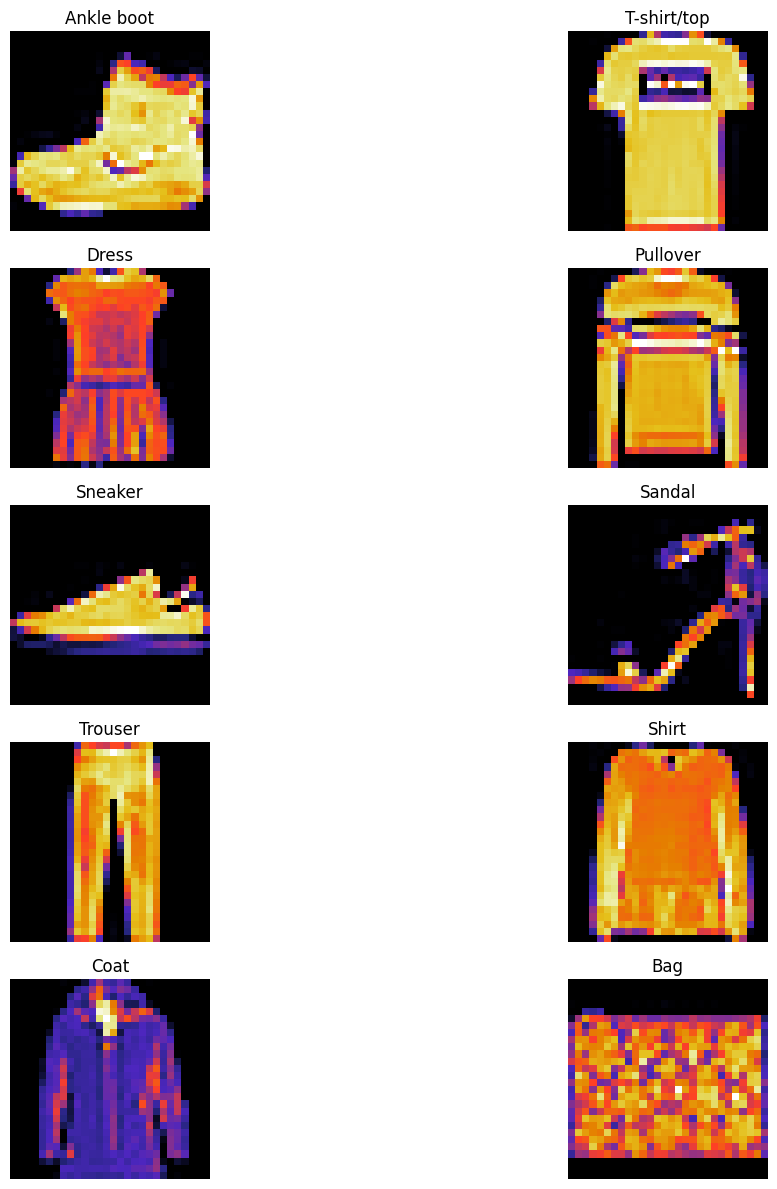

In [11]:
display_unique_samples(train_images, train_labels, LABEL_NAMES)

# Step 5 : Function to prepare image lists for Wandb

In [12]:
def prepare_wandb_images(start_idx, end_idx, images, labels, label_names):
    img_list = [
        wandb.Image(images[i], caption=f"{label_names[labels[i]]} (idx={i})") 
        for i in range(start_idx, end_idx)
    ]
    return img_list

# step 6 : Initialise Wandb to plot in wandb as required , Loading images and then End Wandb session

In [13]:
wandb.init(project="DLassignment1", name="Q1")
image_set_1 = prepare_wandb_images(0, 18, train_images, train_labels, LABEL_NAMES)
image_set_2 = prepare_wandb_images(18, 36, train_images, train_labels, LABEL_NAMES)
wandb.log({"First Batch": image_set_1, "Second Batch": image_set_2})
wandb.finish()

# Q2 : Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes .Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

# Firstly Repeat Step 1 and Step 2 as in Question 1

# step 1 :Loading the dataset 

In [20]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Step 2 : Defining the labels

In [21]:
LABEL_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Step 3 : Normalizing and reshaping the dataset

In [22]:
##################### Normalising & Reshaping
train_images = train_images.reshape(-1, 28*28) / 255.0
test_images = test_images.reshape(-1, 28*28) / 255.0

##################### One hot encoding of labels
train_labels_onehot = np.eye(10)[train_labels]
test_labels_onehot = np.eye(10)[test_labels]

# Step 4 : Implementing the class of Neural Network

In [23]:
class CustomNN:
    # a constructor for default initilisation
    def __init__(self, layers, lr=0.1):
        self.layers = layers
        self.lr = lr
        self.num_layers = len(layers)
        
        # Using "He initialization" to initialize weights 
        self.weights = [np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
                        for i in range(self.num_layers - 1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(self.num_layers - 1)]


    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def softmax(x):
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)


    def forward_pass(self, X):
        self.intermediate_outputs, self.activations = [], [X]
        output = X
        
        for idx in range(len(self.weights) - 1):
            z = output @ self.weights[idx] + self.biases[idx]
            self.intermediate_outputs.append(z)
            output = self.relu(z)
            self.activations.append(output)
        
        final_z = output @ self.weights[-1] + self.biases[-1]
        self.intermediate_outputs.append(final_z)
        final_output = self.softmax(final_z)
        self.activations.append(final_output)
        
        return final_output
    
    
    #def compute_loss(self, predicted, actual):
    #    return -np.sum(actual * np.log(predicted + 1e-8)) / actual.shape[0]
    

    def compute_loss(self, predicted, actual):
        return -np.mean(np.sum(actual * np.log(predicted + 1e-8), axis=1))


    def backward_pass(self, predicted, actual):
        batch_size = actual.shape[0]
        delta = (predicted - actual) / batch_size
        weight_grads, bias_grads = [None] * len(self.weights), [None] * len(self.biases)
        weight_grads[-1] = self.activations[-2].T @ delta
        bias_grads[-1] = np.sum(delta, axis=0, keepdims=True)
        
        for i in range(len(self.weights) - 2, -1, -1):
            delta = (delta @ self.weights[i+1].T) * (self.intermediate_outputs[i] > 0)
            weight_grads[i] = self.activations[i].T @ delta
            bias_grads[i] = np.sum(delta, axis=0, keepdims=True)
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * weight_grads[i]
            self.biases[i] -= self.lr * bias_grads[i]


    def predict(self, X):
        return np.argmax(self.forward_pass(X), axis=1)

# Step 5 : Defining the architecture and parameters

# flexibility !!

In [24]:
hidden_layers = [128, 64, 64]  # Modify this list to change the number of hidden layers and neurons
model_layers = [784] + hidden_layers + [10]  # Input layer, hidden layers, output layer

In [25]:
# Training Parameters
epochs = 20
batch_size = 64
num_batches = train_images.shape[0] // batch_size

# Step 6 : Initialising Wandb , training the neural network and finding the test accuracy

In [28]:
wandb.init(project="DLassignment1", name="Q2")


neural_net = CustomNN(model_layers, lr=0.1)
# Training
for epoch in range(epochs):
    indices = np.random.permutation(train_images.shape[0])
    X_shuffled, y_shuffled = train_images[indices], train_labels_onehot[indices]
    total_loss = 0
    
    for batch in range(num_batches):
        start, end = batch * batch_size, (batch + 1) * batch_size
        X_batch, y_batch = X_shuffled[start:end], y_shuffled[start:end]

        predictions = neural_net.forward_pass(X_batch)
        total_loss += neural_net.compute_loss(predictions, y_batch)
        neural_net.backward_pass(predictions, y_batch)

    avg_loss = total_loss / num_batches
    train_acc = np.mean(neural_net.predict(train_images) == train_labels)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    wandb.log({"Epoch": epoch+1, "Loss": avg_loss, "Training Accuracy": train_acc})

# Test accuracy 
test_acc = np.mean(neural_net.predict(test_images) == test_labels)
print(f"Final Test Accuracy: {test_acc:.4f}")
wandb.log({"Test Accuracy": test_acc})

Epoch 1/20 | Loss: 0.5853 | Training Accuracy: 0.8395
Epoch 2/20 | Loss: 0.4115 | Training Accuracy: 0.8607
Epoch 3/20 | Loss: 0.3694 | Training Accuracy: 0.8796
Epoch 4/20 | Loss: 0.3409 | Training Accuracy: 0.8839
Epoch 5/20 | Loss: 0.3238 | Training Accuracy: 0.8842
Epoch 6/20 | Loss: 0.3087 | Training Accuracy: 0.8962
Epoch 7/20 | Loss: 0.2945 | Training Accuracy: 0.8887
Epoch 8/20 | Loss: 0.2836 | Training Accuracy: 0.8943
Epoch 9/20 | Loss: 0.2740 | Training Accuracy: 0.9000
Epoch 10/20 | Loss: 0.2659 | Training Accuracy: 0.9064
Epoch 11/20 | Loss: 0.2582 | Training Accuracy: 0.9102
Epoch 12/20 | Loss: 0.2504 | Training Accuracy: 0.9134
Epoch 13/20 | Loss: 0.2433 | Training Accuracy: 0.9047
Epoch 14/20 | Loss: 0.2353 | Training Accuracy: 0.9158
Epoch 15/20 | Loss: 0.2349 | Training Accuracy: 0.9198
Epoch 16/20 | Loss: 0.2275 | Training Accuracy: 0.9172
Epoch 17/20 | Loss: 0.2225 | Training Accuracy: 0.9185
Epoch 18/20 | Loss: 0.2155 | Training Accuracy: 0.9259
Epoch 19/20 | Loss:

# Step 7 : Visualisations


Test Sample 10 Probability Distribution:
T-shirt/top: 0.0018
Trouser: 0.0014
Pullover: 0.4473
Dress: 0.0000
Coat: 0.4877
Sandal: 0.0000
Shirt: 0.0616
Sneaker: 0.0000
Bag: 0.0001
Ankle boot: 0.0000


Test Sample 20 Probability Distribution:
T-shirt/top: 0.0124
Trouser: 0.0000
Pullover: 0.9746
Dress: 0.0000
Coat: 0.0006
Sandal: 0.0000
Shirt: 0.0120
Sneaker: 0.0000
Bag: 0.0003
Ankle boot: 0.0000


Test Sample 45 Probability Distribution:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0031
Shirt: 0.0000
Sneaker: 0.9817
Bag: 0.0000
Ankle boot: 0.0152


Test Sample 80 Probability Distribution:
T-shirt/top: 0.0000
Trouser: 0.9994
Pullover: 0.0000
Dress: 0.0004
Coat: 0.0001
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000


Test Sample 980 Probability Distribution:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0028
Bag: 0.0000
Ankle boot: 0.9972


Tes

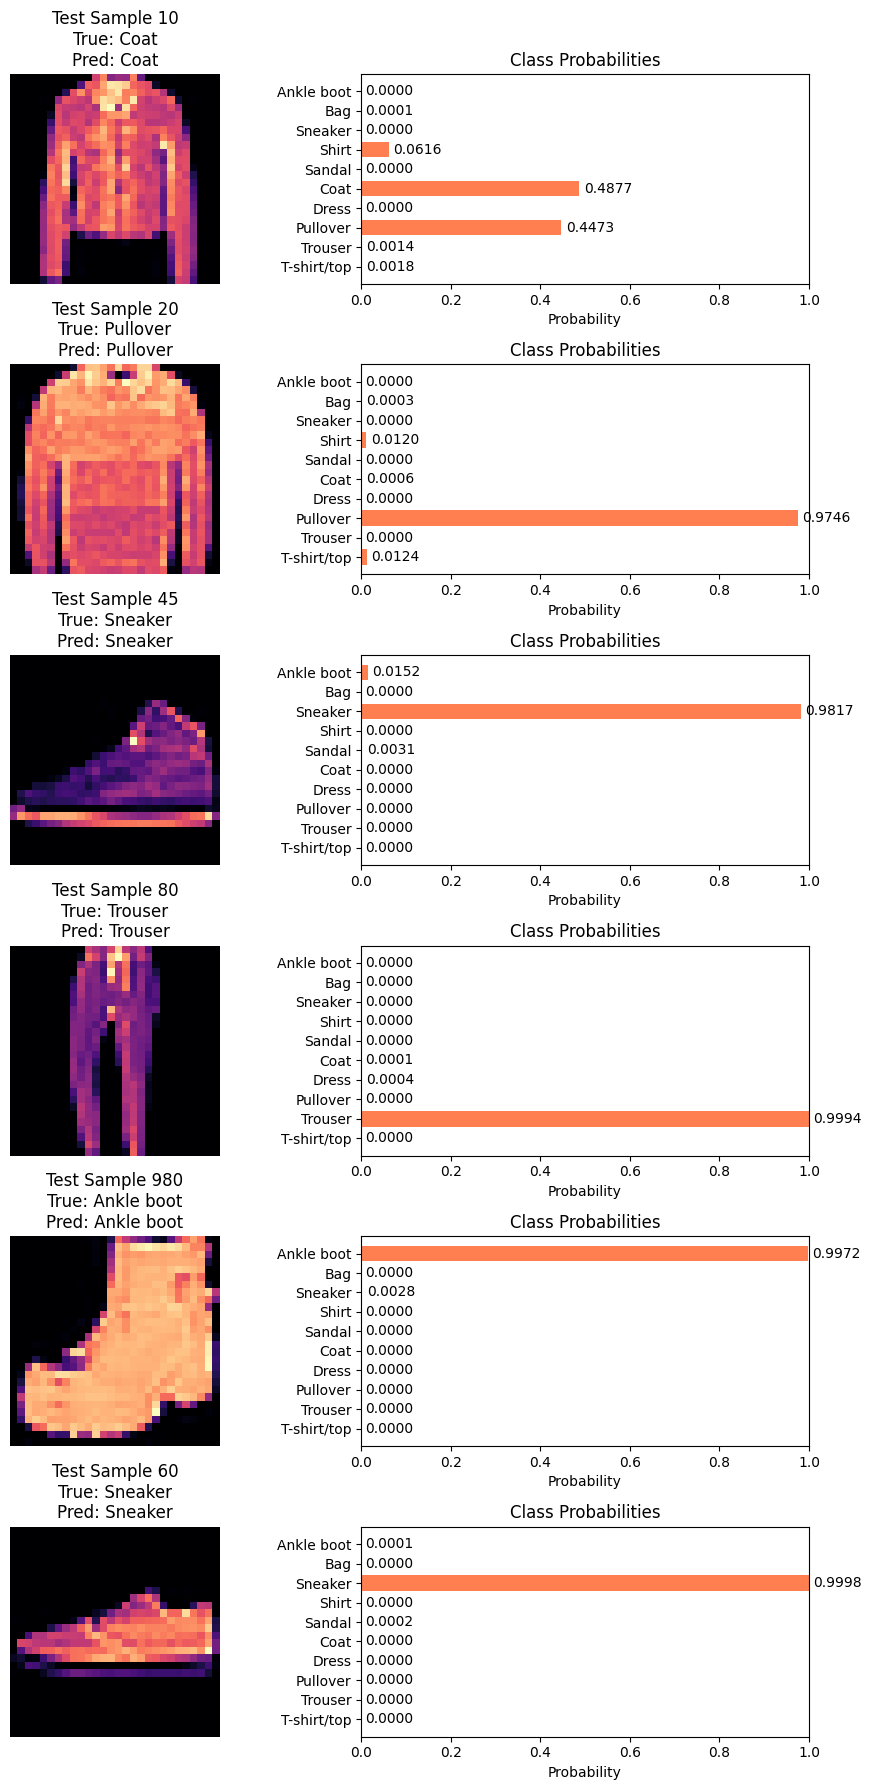

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Test Accuracy,▁
Training Accuracy,▁▃▄▅▅▆▅▅▆▆▇▇▆▇█▇▇█▆█
Epoch,20
Loss,0.20747
Test Accuracy,0.8805
Training Accuracy,0.92435


In [29]:
# test samples for visualization
test_samples = [10, 20, 45, 80, 980, 60]
results_table = []

# Set up figure
fig, axs = plt.subplots(len(test_samples), 2, figsize=(10, len(test_samples) * 3))

for i, sample_idx in enumerate(test_samples):
    prob_distribution = neural_net.forward_pass(test_images[sample_idx:sample_idx+1])
    predicted_label = np.argmax(prob_distribution)

    prob_text = ""
    for j, prob in enumerate(prob_distribution[0]):
        prob_text += f"{LABEL_NAMES[j]}: {prob:.4f}\n"
        results_table.append([sample_idx, LABEL_NAMES[j], prob])

    # Display sample image
    axs[i, 0].imshow(test_images[sample_idx].reshape(28, 28), cmap='magma')
    axs[i, 0].set_title(f"Test Sample {sample_idx}\nTrue: {LABEL_NAMES[test_labels[sample_idx]]}\nPred: {LABEL_NAMES[predicted_label]}")
    axs[i, 0].axis('off')

    # Display class probabilities
    axs[i, 1].barh(LABEL_NAMES, prob_distribution[0], color='coral')
    axs[i, 1].set_xlim(0, 1)
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_title("Class Probabilities")

    for j, prob in enumerate(prob_distribution[0]):
        axs[i, 1].text(prob + 0.01, j, f"{prob:.4f}", va='center')

    print(f"\nTest Sample {sample_idx} Probability Distribution:")
    print(prob_text)

plt.tight_layout()
plt.show()

# Log probability distributions to W&B
probability_table = wandb.Table(data=results_table, columns=["Sample Index", "Class", "Probability"])
wandb.log({"Sample Probability Distributions": probability_table})

wandb.finish()

# Q3 : Implement the backpropagation algorithm with support for the following optimisation functions
    sgd
    momentum based gradient descent
    nesterov accelerated gradient descent
    rmsprop
    adam
    nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.
﻿


# Step 1 : Load the dataset

In [16]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Step 2 : The class labels

In [17]:
LABEL_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Step 3 : Preprocessing and one hot encoding

In [18]:
# Preprocess images
train_images = train_images.reshape(-1, 28 * 28) / 255.0
test_images = test_images.reshape(-1, 28 * 28) / 255.0

# Convert labels to one-hot encoding
train_labels_onehot = np.eye(10)[train_labels]
test_labels_onehot = np.eye(10)[test_labels]

# Step 4 : Algorithm for the optimisers

In [19]:
class NeuralNetwork:
    def __init__(self, layers):
        # Initialize the neural network with given layer sizes.
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i]) for i in range(len(layers)-1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(len(layers)-1)]

    def relu(self, x):
        # Applies ReLU activation.
        return np.maximum(0, x)

    def softmax(self, x):
        # Applies softmax activation for multi-class classification.
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        # Performs forward propagation.
        self.cache_z, self.cache_a = [], [X]
        activation = X
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            self.cache_z.append(z)
            activation = self.relu(z)
            self.cache_a.append(activation)

        final_z = activation @ self.weights[-1] + self.biases[-1]
        self.cache_z.append(final_z)
        output = self.softmax(final_z)
        self.cache_a.append(output)
        return output

    def compute_loss(self, y_pred, y_true):
        # Computes cross-entropy loss.
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    def backward(self, y_pred, y_true):
        # Computes gradients using backpropagation.
        batch_size = y_true.shape[0]
        dW, db = [None] * len(self.weights), [None] * len(self.biases)

        delta = (y_pred - y_true) / batch_size
        dW[-1], db[-1] = self.cache_a[-2].T @ delta, np.sum(delta, axis=0, keepdims=True)

        for i in range(len(self.weights)-2, -1, -1):
            delta = delta @ self.weights[i+1].T * (self.cache_z[i] > 0)
            dW[i], db[i] = self.cache_a[i].T @ delta, np.sum(delta, axis=0, keepdims=True)

        return dW, db

# Step 5 : Optimisers 

In [ ]:
class Optimizer:
    # Base optimizer class to handle initialization of parameters.
    def __init__(self, lr):  # where lr:learning rate
        self.lr = lr

    def update(sts, biases, dW, db, t):
        raise NotImplementedError("Subclasses should implement this method.")


class SGD(Optimizer):
    # Stochastic Gradient Descent Optimizer.
    def __init__(self, lr=0.01):
        super().__init__(lr)

    def update(self, wts,bias, dW, db, t):
        for i in range(len(wts)):
            wts[i] -= self.lr * dW[i]
            bias[i]  -= self.lr * db[i]


class Momentum(Optimizer):
    # Momentum-based Gradient Descent.
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum
        self.state = {}

    def update(self, wts, bias, dW, db, t):
        if not self.state:
            self.state['vw'] = [np.zeros_like(w) for w in wts]
            self.state['vb'] = [np.zeros_like(b) for b in bias]

        for i in range(len(wts)):
            self.state['vw'][i] = self.momentum * self.state['vw'][i] + self.lr * dW[i]
            self.state['vb'][i] = self.momentum * self.state['vb'][i] + self.lr * db[i]
            wts[i] -= self.state['vw'][i]
            bias[i]  -= self.state['vb'][i]


class Nesterov(Momentum):
    # Nesterov Accelerated Gradient Descent.
    def update(self, wts, bias, dW, db, t):
        if not self.state:
            self.state['vw'] = [np.zeros_like(w) for w in wts]
            self.state['vb'] = [np.zeros_like(b) for b in bias]

        for i in range(len(wts)):
            prev_vw = self.state['vw'][i].copy()
            prev_vb = self.state['vb'][i].copy()

            self.state['vw'][i] = self.momentum * self.state['vw'][i] + self.lr * dW[i]
            self.state['vb'][i] = self.momentum * self.state['vb'][i] + self.lr * db[i]

            wts[i] -= -self.momentum * prev_vw + (1 + self.momentum) * self.state['vw'][i]
            bias[i]  -= -self.momentum * prev_vb + (1 + self.momentum) * self.state['vb'][i]


class RMSProp(Optimizer):
    # RMSProp Optimizer
    def __init__(self, lr=0.001, decay_rate=0.9, epsilon=1e-8):
        super().__init__(lr)
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.state = {}

    def update(self, wts, bias, dW, db, t):
        if not self.state:
            self.state['Sw'] = [np.zeros_like(w) for w in wts]
            self.state['Sb'] = [np.zeros_like(b) for b in bias]

        for i in range(len(wts)):
            self.state['Sw'][i] = self.decay_rate * self.state['Sw'][i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.state['Sb'][i] = self.decay_rate * self.state['Sb'][i] + (1 - self.decay_rate) * (db[i] ** 2)

            wts[i] -= self.lr * dW[i] / (np.sqrt(self.state['Sw'][i]) + self.epsilon)
            bias[i]  -= self.lr * db[i] / (np.sqrt(self.state['Sb'][i]) + self.epsilon)


class Adam(Optimizer):
    # Adam Optimizer
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.state = {}

    def update(self, wts, bias, dW, db, t):
        if not self.state:
            self.state['mw'] = [np.zeros_like(w) for w in wts]
            self.state['vw'] = [np.zeros_like(w) for w in wts]
            self.state['mb'] = [np.zeros_like(b) for b in bias]
            self.state['vb'] = [np.zeros_like(b) for b in bias]

        for i in range(len(wts)):
            self.state['mw'][i] = self.beta1 * self.state['mw'][i] + (1 - self.beta1) * dW[i]
            self.state['vw'][i] = self.beta2 * self.state['vw'][i] + (1 - self.beta2) * (dW[i] ** 2)
            self.state['mb'][i] = self.beta1 * self.state['mb'][i] + (1 - self.beta1) * db[i]
            self.state['vb'][i] = self.beta2 * self.state['vb'][i] + (1 - self.beta2) * (db[i] ** 2)

            m_hat_w = self.state['mw'][i] / (1 - self.beta1 ** t)
            v_hat_w = self.state['vw'][i] / (1 - self.beta2 ** t)
            m_hat_b = self.state['mb'][i] / (1 - self.beta1 ** t)
            v_hat_b = self.state['vb'][i] / (1 - self.beta2 ** t)

            wts[i] -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            bias[i]  -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


class Nadam(Adam):
    # Nadam Optimizer (Adam with Nesterov momentum).
    def update(self, wts, bias, dW, db, t):
        if not self.state:
            self.state['mw'] = [np.zeros_like(w) for w in wts]
            self.state['vw'] = [np.zeros_like(w) for w in wts]
            self.state['mb'] = [np.zeros_like(b) for b in bias]
            self.state['vb'] = [np.zeros_like(b) for b in bias]

        for i in range(len(wts)):
            self.state['mw'][i] = self.beta1 * self.state['mw'][i] + (1 - self.beta1) * dW[i]
            self.state['vw'][i] = self.beta2 * self.state['vw'][i] + (1 - self.beta2) * (dW[i] ** 2)
            self.state['mb'][i] = self.beta1 * self.state['mb'][i] + (1 - self.beta1) * db[i]
            self.state['vb'][i] = self.beta2 * self.state['vb'][i] + (1 - self.beta2) * (db[i] ** 2)

            m_hat = self.state['mw'][i] / (1 - self.beta1 ** t)
            v_hat = self.state['vw'][i] / (1 - self.beta2 ** t)
            m_hat_b = self.state['mb'][i] / (1 - self.beta1 ** t)
            v_hat_b = self.state['vb'][i] / (1 - self.beta2 ** t)

            wts[i] -= self.lr * (self.beta1 * m_hat + (1 - self.beta1) * dW[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat) + self.epsilon)
            bias[i]  -= self.lr * (self.beta1 * m_hat_b + (1 - self.beta1) * db[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat_b) + self.epsilon)


# You can add any new optimisation algorithm by just defining a new class and add it to optimizers_dict.

# Step 6 : Defining a dictionary

In [21]:
# Define a dictionary mapping optimizer names to functions that return a new optimizer instance.
optimizers_dict = {
    "SGD": lambda: SGD(lr=0.01),
    "Momentum": lambda: Momentum(lr=0.01, momentum=0.9),
    "Nesterov": lambda: Nesterov(lr=0.01, momentum=0.9),
    "RMSProp": lambda: RMSProp(lr=0.001, decay_rate=0.9),
    "Adam": lambda: Adam(lr=0.001, beta1=0.9, beta2=0.999),
    "Nadam": lambda: Nadam(lr=0.001, beta1=0.9, beta2=0.999)
}

# Step 7 : Common training parameters

In [22]:
num_epochs = 10
batch_size = 64
num_batches = train_images.shape[0] // batch_size



layer_sizes = [784, 128, 64, 10]

# Step 8 : Training and Testing

In [23]:
# To store summary results for each optimizer.
results = []

# Loop over each optimizer and run a separate training experiment.
for opt_name, opt_fn in optimizers_dict.items():
    # Initialize a new wandb run for each optimizer.
    run = wandb.init(project="DLassignment1", 
                     name=f"Q3_{opt_name}", 
                     reinit=True, 
                     config={
                         "optimizer": opt_name,
                         "num_epochs": num_epochs,
                         "batch_size": batch_size,
                         "layer_sizes": layer_sizes
                     })
    
    # Initializing
    nn = NeuralNetwork(layer_sizes)
    optimizer = opt_fn()
    
    global_step = 1
    epoch_losses = []
    
    print(f"\nStarting training with optimizer: {opt_name}")
    for epoch in range(num_epochs):

        # Shuffle training data 
        perm = np.random.permutation(train_images.shape[0])
        X_train_shuffled = train_images[perm]
        y_train_onehot_shuffled = train_labels_onehot[perm]
        
        epoch_loss = 0

        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_onehot_shuffled[start:end]
            
            # Forward pass.
            Y_pred = nn.forward(X_batch)
            loss = nn.compute_loss(Y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass: compute gradients.
            dW, db = nn.backward(Y_pred, y_batch)
            
            # Update parameters 
            optimizer.update(nn.weights, nn.biases, dW, db, global_step)
            global_step += 1
        
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Evaluate training accuracy on the entire training set.
        train_predictions = np.argmax(nn.forward(train_images), axis=1)
        train_accuracy = np.mean(train_predictions == train_labels)
        
        print(f"{opt_name} | Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        wandb.log({"epoch": epoch+1, "loss": avg_loss, "train_accuracy": train_accuracy})
    
    # Evaluate on the test set.
    test_predictions = np.argmax(nn.forward(test_images), axis=1)
    test_accuracy = np.mean(test_predictions == test_labels)
    print(f"{opt_name} | Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"test_accuracy": test_accuracy})
    
    # Save final results for this optimizer.
    results.append({
        "Optimizer": opt_name,
        "Final Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Final Loss": avg_loss
    })
    
    run.finish()



Starting training with optimizer: SGD
SGD | Epoch 1/10 - Loss: 0.8353 - Train Accuracy: 0.8113
SGD | Epoch 2/10 - Loss: 0.5302 - Train Accuracy: 0.8280
SGD | Epoch 3/10 - Loss: 0.4786 - Train Accuracy: 0.8450
SGD | Epoch 4/10 - Loss: 0.4509 - Train Accuracy: 0.8520
SGD | Epoch 5/10 - Loss: 0.4324 - Train Accuracy: 0.8547
SGD | Epoch 6/10 - Loss: 0.4169 - Train Accuracy: 0.8578
SGD | Epoch 7/10 - Loss: 0.4040 - Train Accuracy: 0.8577
SGD | Epoch 8/10 - Loss: 0.3948 - Train Accuracy: 0.8660
SGD | Epoch 9/10 - Loss: 0.3850 - Train Accuracy: 0.8714
SGD | Epoch 10/10 - Loss: 0.3765 - Train Accuracy: 0.8703
SGD | Test Accuracy: 0.8499


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
test_accuracy,▁
train_accuracy,▁▃▅▆▆▆▆▇██
epoch,10
loss,0.37654
test_accuracy,0.8499
train_accuracy,0.87028



Starting training with optimizer: Momentum
Momentum | Epoch 1/10 - Loss: 0.5550 - Train Accuracy: 0.8518
Momentum | Epoch 2/10 - Loss: 0.3981 - Train Accuracy: 0.8716
Momentum | Epoch 3/10 - Loss: 0.3638 - Train Accuracy: 0.8705
Momentum | Epoch 4/10 - Loss: 0.3373 - Train Accuracy: 0.8796
Momentum | Epoch 5/10 - Loss: 0.3199 - Train Accuracy: 0.8899
Momentum | Epoch 6/10 - Loss: 0.3056 - Train Accuracy: 0.8991
Momentum | Epoch 7/10 - Loss: 0.2941 - Train Accuracy: 0.8956
Momentum | Epoch 8/10 - Loss: 0.2845 - Train Accuracy: 0.8940
Momentum | Epoch 9/10 - Loss: 0.2730 - Train Accuracy: 0.9086
Momentum | Epoch 10/10 - Loss: 0.2654 - Train Accuracy: 0.9022
Momentum | Test Accuracy: 0.8731


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▃▄▆▇▆▆█▇
epoch,10
loss,0.26535
test_accuracy,0.8731
train_accuracy,0.90217



Starting training with optimizer: Nesterov
Nesterov | Epoch 1/10 - Loss: 0.5419 - Train Accuracy: 0.8500
Nesterov | Epoch 2/10 - Loss: 0.3938 - Train Accuracy: 0.8724
Nesterov | Epoch 3/10 - Loss: 0.3549 - Train Accuracy: 0.8787
Nesterov | Epoch 4/10 - Loss: 0.3315 - Train Accuracy: 0.8901
Nesterov | Epoch 5/10 - Loss: 0.3107 - Train Accuracy: 0.8864
Nesterov | Epoch 6/10 - Loss: 0.2993 - Train Accuracy: 0.8995
Nesterov | Epoch 7/10 - Loss: 0.2877 - Train Accuracy: 0.8941
Nesterov | Epoch 8/10 - Loss: 0.2772 - Train Accuracy: 0.9059
Nesterov | Epoch 9/10 - Loss: 0.2670 - Train Accuracy: 0.9047
Nesterov | Epoch 10/10 - Loss: 0.2583 - Train Accuracy: 0.9109
Nesterov | Test Accuracy: 0.8821


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▄▄▆▅▇▆▇▇█
epoch,10
loss,0.2583
test_accuracy,0.8821
train_accuracy,0.91087



Starting training with optimizer: RMSProp
RMSProp | Epoch 1/10 - Loss: 0.5267 - Train Accuracy: 0.8629
RMSProp | Epoch 2/10 - Loss: 0.3759 - Train Accuracy: 0.8738
RMSProp | Epoch 3/10 - Loss: 0.3408 - Train Accuracy: 0.8875
RMSProp | Epoch 4/10 - Loss: 0.3212 - Train Accuracy: 0.8961
RMSProp | Epoch 5/10 - Loss: 0.3036 - Train Accuracy: 0.8882
RMSProp | Epoch 6/10 - Loss: 0.2920 - Train Accuracy: 0.9035
RMSProp | Epoch 7/10 - Loss: 0.2832 - Train Accuracy: 0.8998
RMSProp | Epoch 8/10 - Loss: 0.2750 - Train Accuracy: 0.9076
RMSProp | Epoch 9/10 - Loss: 0.2661 - Train Accuracy: 0.8980
RMSProp | Epoch 10/10 - Loss: 0.2624 - Train Accuracy: 0.9133
RMSProp | Test Accuracy: 0.8773


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▄▆▅▇▆▇▆█
epoch,10
loss,0.26236
test_accuracy,0.8773
train_accuracy,0.91335



Starting training with optimizer: Adam
Adam | Epoch 1/10 - Loss: 0.5090 - Train Accuracy: 0.8643
Adam | Epoch 2/10 - Loss: 0.3755 - Train Accuracy: 0.8831
Adam | Epoch 3/10 - Loss: 0.3359 - Train Accuracy: 0.8857
Adam | Epoch 4/10 - Loss: 0.3109 - Train Accuracy: 0.8962
Adam | Epoch 5/10 - Loss: 0.2950 - Train Accuracy: 0.8955
Adam | Epoch 6/10 - Loss: 0.2801 - Train Accuracy: 0.9027
Adam | Epoch 7/10 - Loss: 0.2698 - Train Accuracy: 0.9086
Adam | Epoch 8/10 - Loss: 0.2586 - Train Accuracy: 0.9078
Adam | Epoch 9/10 - Loss: 0.2500 - Train Accuracy: 0.9112
Adam | Epoch 10/10 - Loss: 0.2392 - Train Accuracy: 0.9123
Adam | Test Accuracy: 0.8780


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▂▁▁
test_accuracy,▁
train_accuracy,▁▄▄▆▆▇▇▇██
epoch,10
loss,0.23924
test_accuracy,0.878
train_accuracy,0.9123



Starting training with optimizer: Nadam
Nadam | Epoch 1/10 - Loss: 0.4858 - Train Accuracy: 0.8656
Nadam | Epoch 2/10 - Loss: 0.3653 - Train Accuracy: 0.8842
Nadam | Epoch 3/10 - Loss: 0.3272 - Train Accuracy: 0.8919
Nadam | Epoch 4/10 - Loss: 0.3048 - Train Accuracy: 0.8888
Nadam | Epoch 5/10 - Loss: 0.2878 - Train Accuracy: 0.8970
Nadam | Epoch 6/10 - Loss: 0.2730 - Train Accuracy: 0.9018
Nadam | Epoch 7/10 - Loss: 0.2626 - Train Accuracy: 0.9059
Nadam | Epoch 8/10 - Loss: 0.2517 - Train Accuracy: 0.9041
Nadam | Epoch 9/10 - Loss: 0.2425 - Train Accuracy: 0.9138
Nadam | Epoch 10/10 - Loss: 0.2337 - Train Accuracy: 0.9111
Nadam | Test Accuracy: 0.8770


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▄▅▄▆▆▇▇██
epoch,10
loss,0.23373
test_accuracy,0.877
train_accuracy,0.91112


# Step 9 : Sumarising the results

In [24]:
# Create a wandb Table with the summary results.
summary_table = wandb.Table(columns=["Optimizer", "Final Train Accuracy", "Test Accuracy", "Final Loss"])
for res in results:
    summary_table.add_data(res["Optimizer"], res["Final Train Accuracy"], res["Test Accuracy"], res["Final Loss"])

# summary comparison.
summary_run = wandb.init(project="DLassignment1", name="Q3_summary", reinit=True)
wandb.log({"Optimizer Comparison": summary_table})
summary_run.finish()

# Optionally, print the summary table.
print("\nSummary of Performance of the Optimizers :")
for res in results:
    print(f"{res['Optimizer']:10s} | Train Acc: {res['Final Train Accuracy']:.4f} | Test Acc: {res['Test Accuracy']:.4f} | Final Loss: {res['Final Loss']:.4f}")



Summary of Performance of the Optimizers :
SGD        | Train Acc: 0.8703 | Test Acc: 0.8499 | Final Loss: 0.3765
Momentum   | Train Acc: 0.9022 | Test Acc: 0.8731 | Final Loss: 0.2654
Nesterov   | Train Acc: 0.9109 | Test Acc: 0.8821 | Final Loss: 0.2583
RMSProp    | Train Acc: 0.9133 | Test Acc: 0.8773 | Final Loss: 0.2624
Adam       | Train Acc: 0.9123 | Test Acc: 0.8780 | Final Loss: 0.2392
Nadam      | Train Acc: 0.9111 | Test Acc: 0.8770 | Final Loss: 0.2337


# Q4: Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1 e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, Xavier
    activation functions: sigmoid, tanh, ReLU



# Step 1 : Loading the dataset

In [25]:
(train_images_full, train_labels_full), (test_images, test_labels) = fashion_mnist.load_data()

# Step 2 : Split off 10% of the training set as validation data

In [26]:
val_split = int(0.1 * train_images_full.shape[0]) # 10% split

val_images = train_images_full[:val_split]
val_labels = train_labels_full[:val_split]
train_images = train_images_full[val_split:]
train_labels = train_labels_full[val_split:]

# Step 3 : Flatten and normalize images

In [27]:
train_images = train_images.reshape(-1, 28*28) / 255.0
val_images   = val_images.reshape(-1, 28*28)   / 255.0
test_images  = test_images.reshape(-1, 28*28)  / 255.0

# Step 4 : One hot encoding of the labels

In [30]:
train_labels_oh = np.eye(10)[train_labels]
val_labels_oh   = np.eye(10)[val_labels]
test_labels_oh  = np.eye(10)[test_labels]


# Step 5 : Different values of Hyperparamters (given)

In [31]:
sweep_config = {
    'method': 'bayes',  # or 'grid', 'bayes'
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'epochs': {'values': [5,10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation_function': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}


# Step 6 : Xavier Initialisation 

In [32]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    bound = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-bound, bound, (fan_in, fan_out))

# Step 7 : Neural Network

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, hidden_units, output_size, init_method='random', activation_func='relu', reg_strength=0.0):
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.activation_name = activation_func
        self.reg_strength = reg_strength
        
        # Activation Functions
        if activation_func == 'relu':
            self.activate = lambda x: np.maximum(0, x)
            self.activation_derivative = lambda x: (x > 0).astype(float)
        elif activation_func == 'sigmoid':
            self.activate = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_derivative = lambda x: self.activate(x) * (1 - self.activate(x))
        elif activation_func == 'tanh':
            self.activate = lambda x: np.tanh(x)
            self.activation_derivative = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation function")
        
        # Network Architecture
        layer_sizes = [input_size] + [hidden_units] * hidden_layers + [output_size]
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            fan_in, fan_out = layer_sizes[i], layer_sizes[i + 1]
            if init_method == 'xavier':
                weight_matrix = xavier_init(fan_in, fan_out)
            else:
                weight_matrix = np.random.randn(fan_in, fan_out) * 0.01
            bias_vector = np.zeros((1, fan_out))
            
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)
    

    
    def softmax(self, values):
        exp_values = np.exp(values - np.max(values, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    
    def forward_pass(self, input_data):
        self.layer_inputs = []
        self.activations = [input_data]
        activation = input_data
        
        for i in range(len(self.weights) - 1):
            weighted_sum = activation.dot(self.weights[i]) + self.biases[i]
            self.layer_inputs.append(weighted_sum)
            activation = self.activate(weighted_sum)
            self.activations.append(activation)
        
        final_weighted_sum = activation.dot(self.weights[-1]) + self.biases[-1]
        self.layer_inputs.append(final_weighted_sum)
        output = self.softmax(final_weighted_sum)
        self.activations.append(output)
        return output
    


    def compute_cost(self, predicted_output, true_labels):
        num_samples = true_labels.shape[0]
        log_likelihoods = -np.sum(true_labels * np.log(predicted_output + 1e-8)) / num_samples
        
        # L2 Regularization
        reg_term = 0
        if self.reg_strength > 0:
            reg_term = (self.reg_strength / (2 * num_samples)) * sum(np.sum(W**2) for W in self.weights)
        
        return log_likelihoods + reg_term
    



    def backpropagate(self, predicted_output, true_labels):
        #Computes gradients for weights and biases.
        num_samples = true_labels.shape[0]
        weight_gradients = [None] * len(self.weights)
        bias_gradients = [None] * len(self.biases)
        
        # Compute gradient at output layer
        error = (predicted_output - true_labels) / num_samples
        weight_gradients[-1] = self.activations[-2].T.dot(error)
        bias_gradients[-1] = np.sum(error, axis=0, keepdims=True)
        
        # Compute gradients for hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            error = error.dot(self.weights[i + 1].T) * self.activation_derivative(self.layer_inputs[i])
            weight_gradients[i] = self.activations[i].T.dot(error)
            bias_gradients[i] = np.sum(error, axis=0, keepdims=True)
        
        # Apply L2 Regularization
        if self.reg_strength > 0:
            for i in range(len(self.weights)):
                weight_gradients[i] += (self.reg_strength * self.weights[i]) / num_samples
        
        return weight_gradients, bias_gradients


# Step 8 : Training the model

In [ ]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Step 1.  Build the MLP
        mlp = NeuralNetwork(input_dim=784,num_hidden_layers=config.num_hidden_layers,hidden_size=config.hidden_layer_size,output_dim=10,weight_init=config.weight_init,activation=config.activation_function,weight_decay=config.weight_decay)
        
        # Step 2. Choose the optimizer
        if config.optimizer == 'sgd':
            optimizer = SGD(learning_rate=config.learning_rate)
        elif config.optimizer == 'momentum':
            optimizer = Momentum(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'nesterov':
            optimizer = Nesterov(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'rmsprop':
            optimizer = RMSProp(learning_rate=config.learning_rate, decay_rate=0.9)
        elif config.optimizer == 'adam':
            optimizer = Adam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        elif config.optimizer == 'nadam':
            optimizer = Nadam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        else:
            raise ValueError("Unknown optimizer")
        
        # Step 3. Training loop
        global_step = 1
        for epoch in range(config.epochs):
            
            num_samples = train_images.shape[0]   # Shuffle training data
            indices = np.random.permutation(num_samples)
            X_train_shuffled = train_images[indices]
            y_train_shuffled = train_labels_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
              
                y_pred = mlp.forward(X_batch)    # Forward
                
                
                dW, db = mlp.backward(y_pred, y_batch) # Compute gradients 

              
                optimizer.update(mlp.weights, mlp.biases, dW, db, global_step)     # Optimizer update
                global_step += 1
            
        
            val_pred = mlp.forward(val_images)    # Evaluate on validation set
            val_loss = mlp.compute_loss(val_pred, val_labels_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == val_labels)
            


            # Step 4 : Log to wandb
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Step 5 : Evaluate on test set
        test_pred = mlp.forward(test_images)
        test_loss = mlp.compute_loss(test_pred, test_labels_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == test_labels)
        
        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})
        
    
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}_opt_{config.optimizer}"
        wandb.run.name = run_name
        
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


# Step 9 : Creating the sweep

In [ ]:

sweep_id = wandb.sweep(sweep_config, project="DLassignment1")

wandb.agent(sweep_id, train_model_sweep, count=350)

Create sweep with ID: ysbgm4ic
Sweep URL: https://wandb.ai/snehalma23m020-iit-madras/DLassignment1/sweeps/ysbgm4ic


wandb: Agent Starting Run: xco7zcix with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_16_act_tanh_opt_sgd finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,█▅▁▁▁
val_loss,█▆▅▃▁
epoch,5
test_accuracy,0.1
test_loss,2.30256
val_accuracy,0.09333
val_loss,2.30258


wandb: Agent Starting Run: 17uqfr7y with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid_opt_momentum finished with val_acc=0.0973, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,█▅▇▁▄
val_loss,▄▅█▁▇
epoch,5
test_accuracy,0.1
test_loss,2.30282
val_accuracy,0.09733
val_loss,2.30306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ji8jbpbk with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8862, test_acc=0.8742


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▄▇▇▇▇██
val_loss,█▃▂▄▂▃▂▂▁▁
epoch,10
test_accuracy,0.8742
test_loss,0.35874
val_accuracy,0.88617
val_loss,0.32373


wandb: Agent Starting Run: vdq4bzj8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_rmsprop finished with val_acc=0.8182, test_acc=0.8006


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▆▁▃▁█▇▃▇▇█
val_loss,▃█▇█▁▂▅▂▂▁
epoch,10
test_accuracy,0.8006
test_loss,0.56391
val_accuracy,0.81817
val_loss,0.52854


wandb: Agent Starting Run: r2whedy4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8825, test_acc=0.8749


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇█▇▇
val_loss,█▅▃▃▂▂▁▁▃▂
epoch,10
test_accuracy,0.8749
test_loss,0.35235
val_accuracy,0.8825
val_loss,0.32527


wandb: Agent Starting Run: leoyzp5f with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_adam finished with val_acc=0.8210, test_acc=0.8054


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8054
test_loss,0.59081
val_accuracy,0.821
val_loss,0.56293


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0byfkkd2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8753, test_acc=0.8679


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▆▅█▇▇▇▇
val_loss,█▄▃▃▄▁▂▁▂▃
epoch,10
test_accuracy,0.8679
test_loss,0.3799
val_accuracy,0.87533
val_loss,0.34935


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9pqvadye with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8805, test_acc=0.8705


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▇▇█▇█
val_loss,█▆▄▄▃▂▂▁▂▁
epoch,10
test_accuracy,0.8705
test_loss,0.38187
val_accuracy,0.8805
val_loss,0.3474


wandb: Agent Starting Run: 9t1yc86b with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8805, test_acc=0.8730


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▅█▇▇▇█
val_loss,█▅▅▃▃▁▂▂▂▂
epoch,10
test_accuracy,0.873
test_loss,0.36399
val_accuracy,0.8805
val_loss,0.34016


wandb: Agent Starting Run: vlg3vpx1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8782, test_acc=0.8658


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇█
val_loss,█▂▂▂▁
epoch,5
test_accuracy,0.8658
test_loss,0.37067
val_accuracy,0.87817
val_loss,0.3389


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cs1o8svd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8868, test_acc=0.8803


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▅██▅▇██
val_loss,█▄▃▄▁▂▄▂▁▂
epoch,10
test_accuracy,0.8803
test_loss,0.34507
val_accuracy,0.88683
val_loss,0.32325


wandb: Agent Starting Run: tj8lvxhr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8857, test_acc=0.8831


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▃▇▆██▇
val_loss,█▅▃▂▅▁▃▁▁▂
epoch,10
test_accuracy,0.8831
test_loss,0.32962
val_accuracy,0.88567
val_loss,0.31791


wandb: Agent Starting Run: ry4nqkyp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_adam finished with val_acc=0.8803, test_acc=0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▄█▇▇██▇
val_loss,█▃▄▅▁▁▁▂▁▃
epoch,10
test_accuracy,0.8734
test_loss,0.36809
val_accuracy,0.88033
val_loss,0.35211


wandb: Agent Starting Run: tv6k5jsb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8845, test_acc=0.8718


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▄▆▆▆▇▇█
val_loss,█▆▄▄▂▂▂▁▂▁
epoch,10
test_accuracy,0.8718
test_loss,0.36534
val_accuracy,0.8845
val_loss,0.33541


wandb: Agent Starting Run: 16dxk1ys with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8840, test_acc=0.8776


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▂█▇▆██▇▇
val_loss,▇▇█▁▃▂▂▂▂▄
epoch,10
test_accuracy,0.8776
test_loss,0.37344
val_accuracy,0.884
val_loss,0.34085


wandb: Agent Starting Run: o8b3vc33 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8235, test_acc=0.8092


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇█▇█
val_loss,█▅▃▃▃▂▁▁▁▁
epoch,10
test_accuracy,0.8092
test_loss,0.55346
val_accuracy,0.8235
val_loss,0.52544


wandb: Agent Starting Run: fhvh1ok8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8803, test_acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇█▆▇
val_loss,█▅▃▃▂▂▂▁▂▁
epoch,10
test_accuracy,0.8746
test_loss,0.3572
val_accuracy,0.88033
val_loss,0.32778


wandb: Agent Starting Run: ri4sjn28 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_adam finished with val_acc=0.8882, test_acc=0.8772


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆▇▆▇█▆█
val_loss,█▅▅▃▂▂▁▂▂▁
epoch,10
test_accuracy,0.8772
test_loss,0.34793
val_accuracy,0.88817
val_loss,0.31702


wandb: Agent Starting Run: i36ggsl2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8937, test_acc=0.8805


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▂▁▅▇▆▅▇▇█
val_loss,▇▆█▃▁▂▃▂▁▁
epoch,10
test_accuracy,0.8805
test_loss,0.34447
val_accuracy,0.89367
val_loss,0.31256


wandb: Agent Starting Run: zau8fg9u with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8807, test_acc=0.8742


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆▆▇▅█▇▆
val_loss,█▆▇▃▃▂▅▁▃▃
epoch,10
test_accuracy,0.8742
test_loss,0.35388
val_accuracy,0.88067
val_loss,0.32387


wandb: Agent Starting Run: yk4dzzn0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_adam finished with val_acc=0.8657, test_acc=0.8532


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▆▄▆▇█▅
val_loss,█▄▄▃▃▅▃▂▁▃
epoch,10
test_accuracy,0.8532
test_loss,0.3939
val_accuracy,0.86567
val_loss,0.36045


wandb: Agent Starting Run: udb2r8q9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_nadam finished with val_acc=0.7735, test_acc=0.7630


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▁▆▂▅▅█▆▆▄
val_loss,█▅▂▃▆▃▁▄▁▆
epoch,10
test_accuracy,0.763
test_loss,0.70515
val_accuracy,0.7735
val_loss,0.68391


wandb: Agent Starting Run: k63brzth with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nesterov finished with val_acc=0.8553, test_acc=0.8452


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,0.8452
test_loss,0.43949
val_accuracy,0.85533
val_loss,0.40574


wandb: Agent Starting Run: yvqv68al with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8783, test_acc=0.8709


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇▇█▇
val_loss,█▅▃▃▁▂▂▂▁▁
epoch,10
test_accuracy,0.8709
test_loss,0.37021
val_accuracy,0.87833
val_loss,0.34313


wandb: Agent Starting Run: bhia1kwj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8862, test_acc=0.8760


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▆█
val_loss,█▃▃▃▁
epoch,5
test_accuracy,0.876
test_loss,0.34522
val_accuracy,0.88617
val_loss,0.31856


wandb: Agent Starting Run: wx05wdbn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8848, test_acc=0.8755


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆█
val_loss,█▄▃▃▁
epoch,5
test_accuracy,0.8755
test_loss,0.34875
val_accuracy,0.88483
val_loss,0.32028


wandb: Agent Starting Run: xpnjuixu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8847, test_acc=0.8766


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▇▆████
val_loss,█▅▃▅▄▃▁▃▂▃
epoch,10
test_accuracy,0.8766
test_loss,0.3664
val_accuracy,0.88467
val_loss,0.33996


wandb: Agent Starting Run: q5vsr4wh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8753, test_acc=0.8694


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▅▇▇█▇▇
val_loss,█▃▃▂▃▂▂▁▂▂
epoch,10
test_accuracy,0.8694
test_loss,0.36054
val_accuracy,0.87533
val_loss,0.34679


wandb: Agent Starting Run: 2tqkrwoe with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8658, test_acc=0.8567


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▅▆▆▇▇█
val_loss,█▆▄▃▃▃▃▂▂▁
epoch,10
test_accuracy,0.8567
test_loss,0.417
val_accuracy,0.86583
val_loss,0.39008


wandb: Agent Starting Run: symhwse6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8838, test_acc=0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▂▇█▅▇█
val_loss,█▆▃▃█▂▁▄▂▁
epoch,10
test_accuracy,0.8773
test_loss,0.34585
val_accuracy,0.88383
val_loss,0.32351


wandb: Agent Starting Run: 0dawgkr5 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8718, test_acc=0.8672


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▄▇█▆▄
val_loss,█▅▄▃▂▂▁▂▄▄
epoch,10
test_accuracy,0.8672
test_loss,0.37265
val_accuracy,0.87183
val_loss,0.34749


wandb: Agent Starting Run: pxnzp5zc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8715, test_acc=0.8585


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁█▇▆█
val_loss,█▁▁▃▂
epoch,5
test_accuracy,0.8585
test_loss,0.41613
val_accuracy,0.8715
val_loss,0.38265


wandb: Agent Starting Run: kpfmfjfh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8852, test_acc=0.8769


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅▆▆▆██▇
val_loss,█▅▅▄▃▃▄▁▁▁
epoch,10
test_accuracy,0.8769
test_loss,0.34626
val_accuracy,0.88517
val_loss,0.31836


wandb: Agent Starting Run: h3hwrs7o with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nesterov finished with val_acc=0.8558, test_acc=0.8442


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8442
test_loss,0.4447
val_accuracy,0.85583
val_loss,0.40648


wandb: Agent Starting Run: 5oqxtegy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_rmsprop finished with val_acc=0.8477, test_acc=0.8354


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▄▄█▇█▃▁▇▅
val_loss,▃▃▅▁▂▁▅█▄▄
epoch,10
test_accuracy,0.8354
test_loss,0.55055
val_accuracy,0.84767
val_loss,0.49612


wandb: Agent Starting Run: t3dphvv3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8815, test_acc=0.8683


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆█
val_loss,█▃▄▂▁
epoch,5
test_accuracy,0.8683
test_loss,0.37724
val_accuracy,0.8815
val_loss,0.33285


wandb: Agent Starting Run: t7hunkx5 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8808, test_acc=0.8729


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▆▆▆▆█▇█
val_loss,█▆▃▃▃▃▂▂▂▁
epoch,10
test_accuracy,0.8729
test_loss,0.36175
val_accuracy,0.88083
val_loss,0.33358


wandb: Agent Starting Run: v88sqaz5 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_rmsprop finished with val_acc=0.8752, test_acc=0.8654


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇█▆█▇▇▆█
val_loss,█▂▁▂▄▂▄▃▅▂
epoch,10
test_accuracy,0.8654
test_loss,0.44783
val_accuracy,0.87517
val_loss,0.40324


wandb: Agent Starting Run: nzlzr4yy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8737, test_acc=0.8674


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▁▄▇▆▇█▅
val_loss,█▅▅▇▄▁▃▁▁▃
epoch,10
test_accuracy,0.8674
test_loss,0.38149
val_accuracy,0.87367
val_loss,0.33756


wandb: Agent Starting Run: jdmk8sp2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8565, test_acc=0.8453


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▂▄▆▇▄█▆
val_loss,█▇▃▅▆▃▂▅▁▃
epoch,10
test_accuracy,0.8453
test_loss,0.44505
val_accuracy,0.8565
val_loss,0.41937


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqm2p7sc with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8795, test_acc=0.8733


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▇▇▆██▆
val_loss,█▇▂▅▂▃▂▂▁▂
epoch,10
test_accuracy,0.8733
test_loss,0.35332
val_accuracy,0.8795
val_loss,0.32059


wandb: Agent Starting Run: j0jry7qh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8860, test_acc=0.8804


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅▆▆▆▇█▆▇
val_loss,██▄▃▃▃▂▂▂▁
epoch,10
test_accuracy,0.8804
test_loss,0.33741
val_accuracy,0.886
val_loss,0.30747


wandb: Agent Starting Run: 34mv6ii4 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8713, test_acc=0.8598


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇██
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8598
test_loss,0.38082
val_accuracy,0.87133
val_loss,0.34705


wandb: Agent Starting Run: pruoricx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8840, test_acc=0.8744


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇▅▇████
val_loss,█▃▂▁▃▃▁▁▂▁
epoch,10
test_accuracy,0.8744
test_loss,0.35466
val_accuracy,0.884
val_loss,0.32975


wandb: Agent Starting Run: n1spx9ym with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8857, test_acc=0.8784


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▄▆▇▇▇▅█
val_loss,█▆▂▄▃▁▃▁▇▁
epoch,10
test_accuracy,0.8784
test_loss,0.36618
val_accuracy,0.88567
val_loss,0.33342


wandb: Agent Starting Run: ks316hlg with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8848, test_acc=0.8747


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▄▅▇▇▇▅▇█
val_loss,▅█▄▃▁▁▂▄▂▂
epoch,10
test_accuracy,0.8747
test_loss,0.37739
val_accuracy,0.88483
val_loss,0.34793


wandb: Agent Starting Run: ka2rx5ri with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8842, test_acc=0.8795


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▃▆▄▇▇█▇
val_loss,█▇▃▇▄▃▁▁▁▃
epoch,10
test_accuracy,0.8795
test_loss,0.35819
val_accuracy,0.88417
val_loss,0.33169


wandb: Agent Starting Run: jo62e3b0 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8740, test_acc=0.8638


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅█▆
val_loss,█▃▃▁▃
epoch,5
test_accuracy,0.8638
test_loss,0.39777
val_accuracy,0.874
val_loss,0.35362


wandb: Agent Starting Run: 4vum256f with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8737, test_acc=0.8642


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▁███▆███
val_loss,█▄▆▁▁▁▂▁▂▃
epoch,10
test_accuracy,0.8642
test_loss,0.41747
val_accuracy,0.87367
val_loss,0.38558


wandb: Agent Starting Run: 9d63ijwb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8830, test_acc=0.8753


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅█▆▇▆███
val_loss,█▄▅▂▄▃▃▁▂▂
epoch,10
test_accuracy,0.8753
test_loss,0.35216
val_accuracy,0.883
val_loss,0.32646


wandb: Agent Starting Run: 0vb5wd9v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8755, test_acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▃▆▇▆▇█▇
val_loss,█▆▄▅▂▂▃▂▁▁
epoch,10
test_accuracy,0.8631
test_loss,0.37214
val_accuracy,0.8755
val_loss,0.34128


wandb: Agent Starting Run: b6q0qkxd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8678, test_acc=0.8610


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂▆▄▆▇█▆▆
val_loss,█▅▆▂▄▂▁▁▂▂
epoch,10
test_accuracy,0.861
test_loss,0.38445
val_accuracy,0.86783
val_loss,0.35561


wandb: Agent Starting Run: omcr3wr8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8843, test_acc=0.8756


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▆▅█▅▇▅█
val_loss,█▃▃▂▃▁▂▁▃▁
epoch,10
test_accuracy,0.8756
test_loss,0.35803
val_accuracy,0.88433
val_loss,0.33069


wandb: Agent Starting Run: sdelgl6p with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nesterov finished with val_acc=0.8583, test_acc=0.8448


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8448
test_loss,0.43952
val_accuracy,0.85833
val_loss,0.40232


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wmpksi8z with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8852, test_acc=0.8735


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▆█
val_loss,██▄▃▁
epoch,5
test_accuracy,0.8735
test_loss,0.35067
val_accuracy,0.88517
val_loss,0.32325


wandb: Agent Starting Run: 6d5wjc02 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8312, test_acc=0.8141


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▂█▁█
val_loss,█▅▂▇▁
epoch,5
test_accuracy,0.8141
test_loss,0.53036
val_accuracy,0.83117
val_loss,0.49436


wandb: Agent Starting Run: yqrh3cvs with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8703, test_acc=0.8573


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅█▄
val_loss,█▃▅▁▄
epoch,5
test_accuracy,0.8573
test_loss,0.38702
val_accuracy,0.87033
val_loss,0.35127


wandb: Agent Starting Run: 9whlgv3e with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8865, test_acc=0.8830


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▅▅▆█▅█▆
val_loss,█▇▆▄▅▂▁▄▁▂
epoch,10
test_accuracy,0.883
test_loss,0.33736
val_accuracy,0.8865
val_loss,0.3136


wandb: Agent Starting Run: sczpsyl6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8845, test_acc=0.8735


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▃▅▅▆▆█
val_loss,█▅▄▂▅▅▃▂▂▁
epoch,10
test_accuracy,0.8735
test_loss,0.36235
val_accuracy,0.8845
val_loss,0.33468


wandb: Agent Starting Run: 3f1ndmq5 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8898, test_acc=0.8849


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▅▆█▇▇▆█
val_loss,██▄▃▃▁▂▁▂▁
epoch,10
test_accuracy,0.8849
test_loss,0.33158
val_accuracy,0.88983
val_loss,0.30733


wandb: Agent Starting Run: xawaeqh8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8825, test_acc=0.8713


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▇▆█▅▆█
val_loss,█▆▄▄▂▂▁▄▂▁
epoch,10
test_accuracy,0.8713
test_loss,0.34491
val_accuracy,0.8825
val_loss,0.32181


wandb: Agent Starting Run: 381nh5dt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8827, test_acc=0.8718


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▃█
val_loss,█▂▁▆▁
epoch,5
test_accuracy,0.8718
test_loss,0.36266
val_accuracy,0.88267
val_loss,0.33777


wandb: Agent Starting Run: e6wusvwf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8882, test_acc=0.8838


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▄▇▆▆█▇▇
val_loss,█▅▃▅▁▃▃▁▁▁
epoch,10
test_accuracy,0.8838
test_loss,0.33707
val_accuracy,0.88817
val_loss,0.30706


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: twpa93th with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_nadam finished with val_acc=0.8693, test_acc=0.8599


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▅▄█▇▄▄▄
val_loss,█▆▅▃▄▁▂▅▄▄
epoch,10
test_accuracy,0.8599
test_loss,0.39841
val_accuracy,0.86933
val_loss,0.3647


wandb: Agent Starting Run: hbm4wlbq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8862, test_acc=0.8805


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▂▅█▆▇▇▆▇
val_loss,▇▄█▃▁▂▁▂▃▂
epoch,10
test_accuracy,0.8805
test_loss,0.35363
val_accuracy,0.88617
val_loss,0.32735


wandb: Agent Starting Run: cenz3ycd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8775, test_acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▆▅█▇██▇▇
val_loss,▇█▃▄▁▂▁▂▂▃
epoch,10
test_accuracy,0.8724
test_loss,0.39123
val_accuracy,0.8775
val_loss,0.36512


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6p9g8tk with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8883, test_acc=0.8811


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▄▆▇▅███
val_loss,█▆▅▄▃▁▃▁▃▂
epoch,10
test_accuracy,0.8811
test_loss,0.35036
val_accuracy,0.88833
val_loss,0.31872


wandb: Agent Starting Run: i1cbqvkz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8847, test_acc=0.8699


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▆▅▅▆▆█
val_loss,█▆▄▃▂▂▃▂▂▁
epoch,10
test_accuracy,0.8699
test_loss,0.36075
val_accuracy,0.88467
val_loss,0.33519


wandb: Agent Starting Run: 9exxmgbi with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8833, test_acc=0.8784


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▄▆▆▆███
val_loss,█▆▄▆▂▃▃▂▂▁
epoch,10
test_accuracy,0.8784
test_loss,0.35078
val_accuracy,0.88333
val_loss,0.32518


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8vwky75 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8882, test_acc=0.8803


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▂▅▆▆█▄▇
val_loss,█▅▃▆▄▂▂▁▂▂
epoch,10
test_accuracy,0.8803
test_loss,0.3374
val_accuracy,0.88817
val_loss,0.31922


wandb: Agent Starting Run: ynmn8bi9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_rmsprop finished with val_acc=0.8417, test_acc=0.8219


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▄▁█▆
val_loss,▁▄█▅▄
epoch,5
test_accuracy,0.8219
test_loss,0.57387
val_accuracy,0.84167
val_loss,0.50243


wandb: Agent Starting Run: 6lq2iiy3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8837, test_acc=0.8765


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▄▅▆▆█▇▆
val_loss,█▅▄▅▂▂▁▁▂▃
epoch,10
test_accuracy,0.8765
test_loss,0.34236
val_accuracy,0.88367
val_loss,0.32939


wandb: Agent Starting Run: jplbx3ff with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8745, test_acc=0.8641


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▄▂▄▅█▆▃▇
val_loss,▅█▄▆▆▄▁▄▆▄
epoch,10
test_accuracy,0.8641
test_loss,0.41347
val_accuracy,0.8745
val_loss,0.38983


wandb: Agent Starting Run: eo83ofc6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8847, test_acc=0.8752


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▆▇▇▇█▇▇
val_loss,█▃▄▃▂▂▂▁▂▂
epoch,10
test_accuracy,0.8752
test_loss,0.35405
val_accuracy,0.88467
val_loss,0.31724


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rvqqg42u with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8572, test_acc=0.8492


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▅▄▁▆▆▆▄███
val_loss,▆▆█▄▃▃▆▁▁▁
epoch,10
test_accuracy,0.8492
test_loss,0.4335
val_accuracy,0.85717
val_loss,0.40689


wandb: Agent Starting Run: w50rmlkb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8907, test_acc=0.8802


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▂▆▆▅▄▆█▇
val_loss,██▆▃▂▄▅▃▁▂
epoch,10
test_accuracy,0.8802
test_loss,0.34367
val_accuracy,0.89067
val_loss,0.30833


wandb: Agent Starting Run: dejhn11l with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8310, test_acc=0.8168


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▂█▄█▁█▇▇
val_loss,▆██▂▅▁▆▁▃▁
epoch,10
test_accuracy,0.8168
test_loss,0.53818
val_accuracy,0.831
val_loss,0.50454


wandb: Agent Starting Run: brnsz6kc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8793, test_acc=0.8661


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▇▆▇██▆█▇
val_loss,█▆▂▃▁▂▂▂▁▃
epoch,10
test_accuracy,0.8661
test_loss,0.37827
val_accuracy,0.87933
val_loss,0.34897


wandb: Agent Starting Run: 9xsey1id with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8778, test_acc=0.8624


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▂█
val_loss,█▆▄▄▁
epoch,5
test_accuracy,0.8624
test_loss,0.38414
val_accuracy,0.87783
val_loss,0.34801


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8c6xm76b with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8778, test_acc=0.8713


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆▆▅█▇█▆
val_loss,█▅▅▃▂▃▁▂▂▂
epoch,10
test_accuracy,0.8713
test_loss,0.36811
val_accuracy,0.87783
val_loss,0.33515


wandb: Agent Starting Run: uh7mqwnr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8885, test_acc=0.8792


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▂▆▇▆▇█
val_loss,█▆▅▃▆▂▂▁▁▃
epoch,10
test_accuracy,0.8792
test_loss,0.37636
val_accuracy,0.8885
val_loss,0.33618


wandb: Agent Starting Run: hbns58cr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8908, test_acc=0.8794


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▅▆█▇█▆█
val_loss,██▃▄▄▂▃▁▂▂
epoch,10
test_accuracy,0.8794
test_loss,0.34556
val_accuracy,0.89083
val_loss,0.30775


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rn8e700t with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8875, test_acc=0.8796


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅█▆▅▆█▇█
val_loss,██▃▁▂▃▂▁▃▃
epoch,10
test_accuracy,0.8796
test_loss,0.35566
val_accuracy,0.8875
val_loss,0.33946


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4twt3ci6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8873, test_acc=0.8776


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▁▅▇▇▅▆█▇
val_loss,█▆▇▃▁▂▃▃▁▁
epoch,10
test_accuracy,0.8776
test_loss,0.34428
val_accuracy,0.88733
val_loss,0.31127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ba71beot with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8715, test_acc=0.8618


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆█▇
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8618
test_loss,0.38947
val_accuracy,0.8715
val_loss,0.35349


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zu820eed with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8825, test_acc=0.8716


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▆▆▆█▇▇
val_loss,█▅▃▃▃▃▂▁▂▂
epoch,10
test_accuracy,0.8716
test_loss,0.35864
val_accuracy,0.8825
val_loss,0.32786


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 990xtbdd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8885, test_acc=0.8794


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▃▆▆█▆█▇█
val_loss,█▃▅▃▃▁▃▁▂▂
epoch,10
test_accuracy,0.8794
test_loss,0.35241
val_accuracy,0.8885
val_loss,0.31675


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o0rjk5st with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8813, test_acc=0.8748


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇█▇▇▇█
val_loss,█▅▄▃▂▂▂▂▂▁
epoch,10
test_accuracy,0.8748
test_loss,0.34811
val_accuracy,0.88133
val_loss,0.32697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 081cgsgn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8802, test_acc=0.8717


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8717
test_loss,0.35983
val_accuracy,0.88017
val_loss,0.33112


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xk07zaur with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8885, test_acc=0.8842


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▇▅▅▇█▆█▇
val_loss,██▃▄▃▂▁▃▁▃
epoch,10
test_accuracy,0.8842
test_loss,0.33935
val_accuracy,0.8885
val_loss,0.32507


wandb: Agent Starting Run: 74jdd1bs with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8838, test_acc=0.8755


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▂▅▅▇█▆▇
val_loss,█▅▅▇▄▄▂▁▄▂
epoch,10
test_accuracy,0.8755
test_loss,0.3608
val_accuracy,0.88383
val_loss,0.33498


wandb: Agent Starting Run: fil4fpp1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8733, test_acc=0.8653


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▄█
val_loss,█▅▄▁▁
epoch,5
test_accuracy,0.8653
test_loss,0.39445
val_accuracy,0.87333
val_loss,0.36724


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 543jla50 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8932, test_acc=0.8840


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▆▇▇▆▇█
val_loss,█▆▃▅▃▂▂▄▄▁
epoch,10
test_accuracy,0.884
test_loss,0.32541
val_accuracy,0.89317
val_loss,0.29706


wandb: Agent Starting Run: s2y6kflf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8825, test_acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▂▅▆▆▆▆█
val_loss,█▅▃▆▄▂▃▃▄▁
epoch,10
test_accuracy,0.8725
test_loss,0.36186
val_accuracy,0.8825
val_loss,0.32639


wandb: Agent Starting Run: 3ds81lho with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8890, test_acc=0.8815


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▄▆▇▇▆█
val_loss,█▅▅▄▅▂▂▁▄▁
epoch,10
test_accuracy,0.8815
test_loss,0.3408
val_accuracy,0.889
val_loss,0.31611


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2tw69k42 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8757, test_acc=0.8617


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8617
test_loss,0.39164
val_accuracy,0.87567
val_loss,0.3615


wandb: Agent Starting Run: p4pnnf2e with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8863, test_acc=0.8785


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▆▆█
val_loss,█▄▅▃▃▃▂▂▅▁
epoch,10
test_accuracy,0.8785
test_loss,0.3391
val_accuracy,0.88633
val_loss,0.31173


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o8lhz0im with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_adam finished with val_acc=0.8668, test_acc=0.8645


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▇▇█▇██▆
val_loss,█▃▄▂▂▁▃▁▂▃
epoch,10
test_accuracy,0.8645
test_loss,0.37902
val_accuracy,0.86683
val_loss,0.35832


wandb: Agent Starting Run: a5rwrsbc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8818, test_acc=0.8743


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▇▆█
val_loss,██▁▃▁
epoch,5
test_accuracy,0.8743
test_loss,0.35815
val_accuracy,0.88183
val_loss,0.33118


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kv4czhsl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8860, test_acc=0.8769


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▅▅▇▇██
val_loss,█▇▄▃▄▅▂▂▂▁
epoch,10
test_accuracy,0.8769
test_loss,0.34751
val_accuracy,0.886
val_loss,0.31402


wandb: Agent Starting Run: t3upsutr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8778, test_acc=0.8717


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▇▇▆███
val_loss,█▅▅▃▂▃▃▁▂▁
epoch,10
test_accuracy,0.8717
test_loss,0.35494
val_accuracy,0.87783
val_loss,0.33154


wandb: Agent Starting Run: y19avwhf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8837, test_acc=0.8703


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▂▆▅▆███▇
val_loss,█▅▆▂▂▃▂▁▂▂
epoch,10
test_accuracy,0.8703
test_loss,0.3583
val_accuracy,0.88367
val_loss,0.32617


wandb: Agent Starting Run: nvrz3mov with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8533, test_acc=0.8412


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▂▅▆▇▁▃▆▅█
val_loss,▆█▄▃▃▇▆▃▅▁
epoch,10
test_accuracy,0.8412
test_loss,0.45403
val_accuracy,0.85333
val_loss,0.42331


wandb: Agent Starting Run: cjlfws9t with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8767, test_acc=0.8629


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.8629
test_loss,0.37943
val_accuracy,0.87667
val_loss,0.34975


wandb: Agent Starting Run: jrchhzdh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8785, test_acc=0.8629


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8629
test_loss,0.37724
val_accuracy,0.8785
val_loss,0.34339


wandb: Agent Starting Run: rb0utm9i with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8733, test_acc=0.8653


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8653
test_loss,0.38674
val_accuracy,0.87333
val_loss,0.35674


wandb: Agent Starting Run: ltypeohu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8890, test_acc=0.8812


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▆▆▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8812
test_loss,0.33964
val_accuracy,0.889
val_loss,0.31367


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: raginzxc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8858, test_acc=0.8768


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄█▅▆▇▆██
val_loss,█▅▄▁▄▃▁▃▁▁
epoch,10
test_accuracy,0.8768
test_loss,0.35068
val_accuracy,0.88583
val_loss,0.31563


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vd9dq3cn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8898, test_acc=0.8766


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▄▆▇████
val_loss,█▅▃▄▃▂▁▂▁▂
epoch,10
test_accuracy,0.8766
test_loss,0.35643
val_accuracy,0.88983
val_loss,0.32546


wandb: Agent Starting Run: bzrpqxws with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8692, test_acc=0.8646


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇█▆
val_loss,█▃▂▁▃
epoch,5
test_accuracy,0.8646
test_loss,0.38506
val_accuracy,0.86917
val_loss,0.36045


wandb: Agent Starting Run: 5yv3vno0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_nadam finished with val_acc=0.8607, test_acc=0.8477


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆█▆
val_loss,█▄▄▁▅
epoch,5
test_accuracy,0.8477
test_loss,0.43789
val_accuracy,0.86067
val_loss,0.40667


wandb: Agent Starting Run: 2baljmg9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8747, test_acc=0.8619


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁██▆█
val_loss,█▂▁▂▁
epoch,5
test_accuracy,0.8619
test_loss,0.36864
val_accuracy,0.87467
val_loss,0.33401


wandb: Agent Starting Run: t8fug3u8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8463, test_acc=0.8332


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▅▆█▅█▃▃
val_loss,█▅▄▂▂▂▃▁▄▄
epoch,10
test_accuracy,0.8332
test_loss,0.46572
val_accuracy,0.84633
val_loss,0.43307


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6vwxxgm2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8777, test_acc=0.8701


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇██▇▇█
val_loss,█▆▄▃▃▂▂▂▂▁
epoch,10
test_accuracy,0.8701
test_loss,0.35913
val_accuracy,0.87767
val_loss,0.33853


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9u52p4c1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8653, test_acc=0.8570


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅█▆
val_loss,█▄▃▁▂
epoch,5
test_accuracy,0.857
test_loss,0.39146
val_accuracy,0.86533
val_loss,0.3637


wandb: Agent Starting Run: 6wojafju with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8743, test_acc=0.8640


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▂▆█
val_loss,█▇▆▂▁
epoch,5
test_accuracy,0.864
test_loss,0.38818
val_accuracy,0.87433
val_loss,0.35481


wandb: Agent Starting Run: vz4hr1cl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8747, test_acc=0.8631


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇█▇█▇█
val_loss,█▃▃▂▂▁▂▁▂▁
epoch,10
test_accuracy,0.8631
test_loss,0.38402
val_accuracy,0.87467
val_loss,0.34728


wandb: Agent Starting Run: 4z9pbaxm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8843, test_acc=0.8685


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▆▆▇█▆█
val_loss,█▅▃▂▃▃▂▁▂▁
epoch,10
test_accuracy,0.8685
test_loss,0.36735
val_accuracy,0.88433
val_loss,0.3345


wandb: Agent Starting Run: 2rhbczoj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8753, test_acc=0.8640


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▆▇██▇
val_loss,█▄▃▂▂▃▂▁▁▁
epoch,10
test_accuracy,0.864
test_loss,0.37353
val_accuracy,0.87533
val_loss,0.34278


wandb: Agent Starting Run: ob1bcmq6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_adam finished with val_acc=0.8885, test_acc=0.8792


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▁▂▅▆█▇██
val_loss,█▆▆▆▄▃▁▃▂▂
epoch,10
test_accuracy,0.8792
test_loss,0.34958
val_accuracy,0.8885
val_loss,0.316


wandb: Agent Starting Run: op54sx12 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8895, test_acc=0.8803


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▅▆▆▇█▅█
val_loss,█▇▄▄▂▄▂▁▃▁
epoch,10
test_accuracy,0.8803
test_loss,0.3402
val_accuracy,0.8895
val_loss,0.31052


wandb: Agent Starting Run: r106nafe with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8787, test_acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▆▇██
val_loss,█▅▃▃▃▃▃▂▁▁
epoch,10
test_accuracy,0.8719
test_loss,0.35571
val_accuracy,0.87867
val_loss,0.32666


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hckwy80m with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8877, test_acc=0.8751


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅▂▇▅▇██
val_loss,█▅▅▄▆▂▃▂▂▁
epoch,10
test_accuracy,0.8751
test_loss,0.35425
val_accuracy,0.88767
val_loss,0.31112


wandb: Agent Starting Run: vnkrlpoi with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8787, test_acc=0.8701


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▄▆█▇█▆▇
val_loss,█▃▃▆▂▃▇▄▄▁
epoch,10
test_accuracy,0.8701
test_loss,0.36668
val_accuracy,0.87867
val_loss,0.33411


wandb: Agent Starting Run: 4be2ba2y with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8812, test_acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆█▇▇▅██
val_loss,█▅▃▂▂▂▂▄▁▁
epoch,10
test_accuracy,0.8746
test_loss,0.35895
val_accuracy,0.88117
val_loss,0.33116


wandb: Agent Starting Run: 6nf2y36n with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8880, test_acc=0.8791


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▄▇▅▇▇▅█
val_loss,█▆▅▅▂▅▂▁▃▂
epoch,10
test_accuracy,0.8791
test_loss,0.34818
val_accuracy,0.888
val_loss,0.32369


wandb: Agent Starting Run: ji361cpq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8665, test_acc=0.8604


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▅█▆▄▆▄▃
val_loss,▆▆▄▃▁▂▃▂▅█
epoch,10
test_accuracy,0.8604
test_loss,0.44371
val_accuracy,0.8665
val_loss,0.41749


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jk6q0nkx with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8632, test_acc=0.8482


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▄▅█
val_loss,█▃▃▃▁
epoch,5
test_accuracy,0.8482
test_loss,0.44097
val_accuracy,0.86317
val_loss,0.4133


wandb: Agent Starting Run: yz7042wm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8767, test_acc=0.8634


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆█▆
val_loss,█▆▃▁▃
epoch,5
test_accuracy,0.8634
test_loss,0.38035
val_accuracy,0.87667
val_loss,0.33753


wandb: Agent Starting Run: m4qlbzdb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8930, test_acc=0.8789


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▄▅▅▆██
val_loss,█▆▂▄▅▄▃▁▁▁
epoch,10
test_accuracy,0.8789
test_loss,0.3445
val_accuracy,0.893
val_loss,0.31022


wandb: Agent Starting Run: 8vw59z7a with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8897, test_acc=0.8833


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▅▆▄█▆█
val_loss,█▆▄▄▄▃▃▁▂▁
epoch,10
test_accuracy,0.8833
test_loss,0.32472
val_accuracy,0.88967
val_loss,0.30415


wandb: Agent Starting Run: kq4hhrlc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8867, test_acc=0.8785


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇▇▇██▇█
val_loss,█▃▂▁▂▂▁▁▁▁
epoch,10
test_accuracy,0.8785
test_loss,0.36347
val_accuracy,0.88667
val_loss,0.32676


wandb: Agent Starting Run: pntqkybt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8710, test_acc=0.8611


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▇▇█▃▇█▅
val_loss,▇█▄▃▂▂▅▁▁▄
epoch,10
test_accuracy,0.8611
test_loss,0.39096
val_accuracy,0.871
val_loss,0.35225


wandb: Agent Starting Run: 3wcn8xit with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8930, test_acc=0.8787


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▄▅▅▆▇▆█
val_loss,█▇▂▄▂▃▂▂▂▁
epoch,10
test_accuracy,0.8787
test_loss,0.33761
val_accuracy,0.893
val_loss,0.30956


wandb: Agent Starting Run: x8emqv34 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8763, test_acc=0.8632


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆██
val_loss,█▄▅▁▂
epoch,5
test_accuracy,0.8632
test_loss,0.38761
val_accuracy,0.87633
val_loss,0.33919


wandb: Agent Starting Run: 3m2y8ss9 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8862, test_acc=0.8762


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄█▇▆▇▃██
val_loss,█▅▅▁▂▄▁▇▂▁
epoch,10
test_accuracy,0.8762
test_loss,0.34409
val_accuracy,0.88617
val_loss,0.31932


wandb: Agent Starting Run: g9nsqabt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.0973, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▇▅▅▇▆▁▅▅▅
val_loss,▁▂▅▄▅▄█▁▄▇
epoch,10
test_accuracy,0.1
test_loss,2.30267
val_accuracy,0.09733
val_loss,2.30292


wandb: Agent Starting Run: fitxgcki with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8503, test_acc=0.8404


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▇█████
val_loss,█▆▅▃▂▁▁▁▁▁
epoch,10
test_accuracy,0.8404
test_loss,0.46064
val_accuracy,0.85033
val_loss,0.42952


wandb: Agent Starting Run: mykuv528 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8698, test_acc=0.8615


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.8615
test_loss,0.40549
val_accuracy,0.86983
val_loss,0.38073


wandb: Agent Starting Run: vf7ux36i with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8703, test_acc=0.8577


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▂▁
epoch,5
test_accuracy,0.8577
test_loss,0.40052
val_accuracy,0.87033
val_loss,0.36639


wandb: Agent Starting Run: 4r7vfwvj with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid_opt_adam finished with val_acc=0.4525, test_acc=0.4480


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.448
test_loss,1.20126
val_accuracy,0.4525
val_loss,1.19497


wandb: Agent Starting Run: 5xrti6s3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8860, test_acc=0.8753


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▆▇▄▇▇██
val_loss,█▅▅▂▂▄▂▂▁▁
epoch,10
test_accuracy,0.8753
test_loss,0.35546
val_accuracy,0.886
val_loss,0.3148


wandb: Agent Starting Run: ze531316 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8818, test_acc=0.8743


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆█▅█
val_loss,█▃▁▃▁
epoch,5
test_accuracy,0.8743
test_loss,0.35743
val_accuracy,0.88183
val_loss,0.32462


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hs2vqen9 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8793, test_acc=0.8706


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8706
test_loss,0.36855
val_accuracy,0.87933
val_loss,0.34625


wandb: Agent Starting Run: zibe0g20 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8762, test_acc=0.8739


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅█▆████
val_loss,█▅▄▄▂▃▁▁▁▁
epoch,10
test_accuracy,0.8739
test_loss,0.36248
val_accuracy,0.87617
val_loss,0.3369


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8a43ve1s with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_momentum finished with val_acc=0.8638, test_acc=0.8519


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8519
test_loss,0.4258
val_accuracy,0.86383
val_loss,0.39475


wandb: Agent Starting Run: i4em7gkw with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8862, test_acc=0.8798


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▆▇▇▇▇▇█
val_loss,█▅▄▂▂▁▂▁▁▁
epoch,10
test_accuracy,0.8798
test_loss,0.34004
val_accuracy,0.88617
val_loss,0.31618


wandb: Agent Starting Run: 1xxanlfg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8765, test_acc=0.8708


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▅▆▄█▇█
val_loss,█▄▂▃▃▂▄▁▁▁
epoch,10
test_accuracy,0.8708
test_loss,0.36925
val_accuracy,0.8765
val_loss,0.34468


wandb: Agent Starting Run: rf2r1pgu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8875, test_acc=0.8750


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▃▃▅▅██▅█
val_loss,█▇▅▆▄▅▁▂▃▂
epoch,10
test_accuracy,0.875
test_loss,0.34558
val_accuracy,0.8875
val_loss,0.32904


wandb: Agent Starting Run: fq70eyw6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8803, test_acc=0.8703


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▆▇▇███
val_loss,█▄▃▂▃▂▂▁▁▁
epoch,10
test_accuracy,0.8703
test_loss,0.35533
val_accuracy,0.88033
val_loss,0.33074


wandb: Agent Starting Run: ovukjlpo with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8180, test_acc=0.8073


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄██
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.8073
test_loss,0.56987
val_accuracy,0.818
val_loss,0.54529


wandb: Agent Starting Run: n3zq49d1 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8887, test_acc=0.8795


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂█▇▅▄▃▄█
val_loss,█▆▆▂▁▂▄▃▃▁
epoch,10
test_accuracy,0.8795
test_loss,0.34881
val_accuracy,0.88867
val_loss,0.31332


wandb: Agent Starting Run: b77dh9l3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8758, test_acc=0.8664


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8664
test_loss,0.37687
val_accuracy,0.87583
val_loss,0.34816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rbgeir97 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_momentum finished with val_acc=0.8693, test_acc=0.8566


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8566
test_loss,0.39541
val_accuracy,0.86933
val_loss,0.36482


wandb: Agent Starting Run: pmw9kkmb with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8847, test_acc=0.8799


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▆▅▆▅█▇
val_loss,█▄▄▂▂▃▁▃▁▁
epoch,10
test_accuracy,0.8799
test_loss,0.33933
val_accuracy,0.88467
val_loss,0.31769


wandb: Agent Starting Run: 7pplvphw with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_rmsprop finished with val_acc=0.8565, test_acc=0.8457


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▄▂▂▂▁▁▂▁
epoch,10
test_accuracy,0.8457
test_loss,0.44458
val_accuracy,0.8565
val_loss,0.41741


wandb: Agent Starting Run: ao2zs7pk with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8688, test_acc=0.8624


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▆███▇
val_loss,█▅▄▃▃▃▂▁▁▂
epoch,10
test_accuracy,0.8624
test_loss,0.37997
val_accuracy,0.86883
val_loss,0.35307


wandb: Agent Starting Run: pimq4i1e with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8795, test_acc=0.8646


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇█
val_loss,█▃▃▂▁
epoch,5
test_accuracy,0.8646
test_loss,0.37024
val_accuracy,0.8795
val_loss,0.33017


wandb: Agent Starting Run: mng2bvz2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_adam finished with val_acc=0.8752, test_acc=0.8705


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▆▆▇▇█▇▇
val_loss,█▃▂▃▂▂▁▁▂▁
epoch,10
test_accuracy,0.8705
test_loss,0.36174
val_accuracy,0.87517
val_loss,0.33995


wandb: Agent Starting Run: i33oq4x3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8843, test_acc=0.8810


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅▅▇█▇█▇█
val_loss,█▄▄▃▂▂▂▁▂▁
epoch,10
test_accuracy,0.881
test_loss,0.33993
val_accuracy,0.88433
val_loss,0.3063


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ql2zxfee with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8900, test_acc=0.8824


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▆▅▆▇▄▇█
val_loss,█▅▃▃▃▃▂▄▂▁
epoch,10
test_accuracy,0.8824
test_loss,0.33415
val_accuracy,0.89
val_loss,0.29996


wandb: Agent Starting Run: 8j0val6m with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8908, test_acc=0.8846


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▅▆▅██▆█
val_loss,█▇▃▄▃▃▁▁▃▁
epoch,10
test_accuracy,0.8846
test_loss,0.33451
val_accuracy,0.89083
val_loss,0.31323


wandb: Agent Starting Run: 1klr8bjq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_adam finished with val_acc=0.8735, test_acc=0.8662


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▅▇▇██▇▇
val_loss,█▇▆▄▂▂▁▁▂▂
epoch,10
test_accuracy,0.8662
test_loss,0.38013
val_accuracy,0.8735
val_loss,0.34897


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c7gyr5gd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8770, test_acc=0.8673


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▆▆▇▇██
val_loss,█▅▃▃▂▃▁▂▁▁
epoch,10
test_accuracy,0.8673
test_loss,0.37114
val_accuracy,0.877
val_loss,0.34773


wandb: Agent Starting Run: 1fkgyfgx with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8853, test_acc=0.8762


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▂▁
epoch,10
test_accuracy,0.8762
test_loss,0.34917
val_accuracy,0.88533
val_loss,0.32875


wandb: Agent Starting Run: 0zehrnze with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8757, test_acc=0.8662


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▅█
val_loss,█▆▅▄▁
epoch,5
test_accuracy,0.8662
test_loss,0.37823
val_accuracy,0.87567
val_loss,0.3502


wandb: Agent Starting Run: pdhu5aa8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8520, test_acc=0.8404


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8404
test_loss,0.45899
val_accuracy,0.852
val_loss,0.43802


wandb: Agent Starting Run: zp99n8wg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_momentum finished with val_acc=0.8448, test_acc=0.8309


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
test_accuracy,0.8309
test_loss,0.48638
val_accuracy,0.84483
val_loss,0.45479


wandb: Agent Starting Run: bphupmet with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8880, test_acc=0.8764


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▅▇▇█▇
val_loss,█▅▄▃▃▃▂▂▁▂
epoch,10
test_accuracy,0.8764
test_loss,0.34889
val_accuracy,0.888
val_loss,0.31879


wandb: Agent Starting Run: g1flsvel with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8727, test_acc=0.8687


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▅▄▅█▅▅
val_loss,█▆▄▂▄▄▂▁▃▁
epoch,10
test_accuracy,0.8687
test_loss,0.36566
val_accuracy,0.87267
val_loss,0.33675


wandb: Agent Starting Run: pc76gozy with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8780, test_acc=0.8687


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆█
val_loss,█▅▆▁▁
epoch,5
test_accuracy,0.8687
test_loss,0.37057
val_accuracy,0.878
val_loss,0.34171


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p0sn8ptk with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8838, test_acc=0.8783


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▅▅▇▇██▆
val_loss,█▆▄▃▃▃▃▁▃▃
epoch,10
test_accuracy,0.8783
test_loss,0.34494
val_accuracy,0.88383
val_loss,0.32228


wandb: Agent Starting Run: zzmjencp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8787, test_acc=0.8690


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▃▆▅▄▇▇█
val_loss,█▄▃▆▃▅▅▂▂▁
epoch,10
test_accuracy,0.869
test_loss,0.36096
val_accuracy,0.87867
val_loss,0.33751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72tk1g2d with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8873, test_acc=0.8797


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▅▆█▇██
val_loss,█▄▃▃▄▂▁▁▁▁
epoch,10
test_accuracy,0.8797
test_loss,0.34412
val_accuracy,0.88733
val_loss,0.31333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0lakzzs with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8912, test_acc=0.8854


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂▇▇▇▆▇██
val_loss,█▅▆▂▂▁▂▂▁▁
epoch,10
test_accuracy,0.8854
test_loss,0.32757
val_accuracy,0.89117
val_loss,0.29834


wandb: Agent Starting Run: f0l6jsis with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8525, test_acc=0.8415


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄█▇
val_loss,█▆▂▂▁
epoch,5
test_accuracy,0.8415
test_loss,0.43426
val_accuracy,0.8525
val_loss,0.39325


wandb: Agent Starting Run: w9kp3b03 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8820, test_acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8725
test_loss,0.36209
val_accuracy,0.882
val_loss,0.32657


wandb: Agent Starting Run: cgrttc84 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8807, test_acc=0.8763


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▇▇█▇▇▆█
val_loss,█▄▄▂▁▁▂▂▄▁
epoch,10
test_accuracy,0.8763
test_loss,0.36803
val_accuracy,0.88067
val_loss,0.34172


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a55twjn9 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8753, test_acc=0.8669


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▄▇█
val_loss,█▄▅▁▁
epoch,5
test_accuracy,0.8669
test_loss,0.37354
val_accuracy,0.87533
val_loss,0.34359


wandb: Agent Starting Run: 5eh6f7f7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8858, test_acc=0.8783


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▄▅▇▇█▇█
val_loss,█▅▃▅▄▂▂▁▂▁
epoch,10
test_accuracy,0.8783
test_loss,0.34181
val_accuracy,0.88583
val_loss,0.31454


wandb: Agent Starting Run: dl3x4peq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8780, test_acc=0.8694


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▆▆▇█▇█
val_loss,█▅▃▄▂▃▂▂▂▁
epoch,10
test_accuracy,0.8694
test_loss,0.36193
val_accuracy,0.878
val_loss,0.33617


wandb: Agent Starting Run: iodqqlnu with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8898, test_acc=0.8774


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▂▄▄▅▇▆██
val_loss,█▄▅▅▄▃▁▂▁▁
epoch,10
test_accuracy,0.8774
test_loss,0.34658
val_accuracy,0.88983
val_loss,0.3218


wandb: Agent Starting Run: lim5cwmn with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8815, test_acc=0.8729


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▃▅██▇▇▇
val_loss,█▇▃▅▄▁▂▂▂▃
epoch,10
test_accuracy,0.8729
test_loss,0.35923
val_accuracy,0.8815
val_loss,0.33624


wandb: Agent Starting Run: isg2k2eu with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8817, test_acc=0.8720


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▃▅▆▆█▇
val_loss,█▅▄▂▄▂▂▂▁▁
epoch,10
test_accuracy,0.872
test_loss,0.35402
val_accuracy,0.88167
val_loss,0.32201


wandb: Agent Starting Run: 4xyldftw with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8755, test_acc=0.8657


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▂██
val_loss,█▃▇▁▂
epoch,5
test_accuracy,0.8657
test_loss,0.38117
val_accuracy,0.8755
val_loss,0.34806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iv4ixype with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8797, test_acc=0.8755


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▇█▇██
val_loss,█▅▄▃▃▂▁▂▂▁
epoch,10
test_accuracy,0.8755
test_loss,0.3508
val_accuracy,0.87967
val_loss,0.32812


wandb: Agent Starting Run: jvc5v7mr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8917, test_acc=0.8793


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▃▆▅██
val_loss,█▅▄▃▂▅▂▄▁▁
epoch,10
test_accuracy,0.8793
test_loss,0.33935
val_accuracy,0.89167
val_loss,0.31028


wandb: Agent Starting Run: 5c392hl6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8908, test_acc=0.8870


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▆▇▇▇▅▇█
val_loss,█▃▃▂▁▁▁▃▁▁
epoch,10
test_accuracy,0.887
test_loss,0.3312
val_accuracy,0.89083
val_loss,0.30654


wandb: Agent Starting Run: 5w4m1s3d with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8783, test_acc=0.8742


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▄▅▇▃▆█▇
val_loss,█▅▃▃▃▁▅▁▁▂
epoch,10
test_accuracy,0.8742
test_loss,0.35902
val_accuracy,0.87833
val_loss,0.33944


wandb: Agent Starting Run: xjebxk1j with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8813, test_acc=0.8747


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,█▄▃▁▁
epoch,5
test_accuracy,0.8747
test_loss,0.34644
val_accuracy,0.88133
val_loss,0.32684


wandb: Agent Starting Run: 8oz14pje with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8712, test_acc=0.8635


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▇▄▆▆█▇▇
val_loss,█▇▃▃▅▃▃▁▁▃
epoch,10
test_accuracy,0.8635
test_loss,0.38414
val_accuracy,0.87117
val_loss,0.35677


wandb: Agent Starting Run: vvglb1r7 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8840, test_acc=0.8763


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▇▇▇▇▆▇█
val_loss,█▄▂▂▂▂▂▃▁▁
epoch,10
test_accuracy,0.8763
test_loss,0.36038
val_accuracy,0.884
val_loss,0.33165


wandb: Agent Starting Run: tjpq3ras with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8820, test_acc=0.8688


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▄▆▇▆█▇█▆
val_loss,▇█▅▃▂▃▁▂▁▃
epoch,10
test_accuracy,0.8688
test_loss,0.36635
val_accuracy,0.882
val_loss,0.32293


wandb: Agent Starting Run: jk35rmwp with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8845, test_acc=0.8733


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▄███▇██
val_loss,█▄▃▅▂▁▁▂▁▁
epoch,10
test_accuracy,0.8733
test_loss,0.36017
val_accuracy,0.8845
val_loss,0.3263


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uw2zimf8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8792, test_acc=0.8715


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▆▇▆▆██▇
val_loss,█▅▅▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8715
test_loss,0.35496
val_accuracy,0.87917
val_loss,0.32166


wandb: Agent Starting Run: tzd4sm2u with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8765, test_acc=0.8672


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8672
test_loss,0.36888
val_accuracy,0.8765
val_loss,0.34478


wandb: Agent Starting Run: dkmshlhp with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8742, test_acc=0.8653


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇▇█▇
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8653
test_loss,0.37974
val_accuracy,0.87417
val_loss,0.34746


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 66d6s4hv with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_adam finished with val_acc=0.8757, test_acc=0.8645


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8645
test_loss,0.38401
val_accuracy,0.87567
val_loss,0.355


wandb: Agent Starting Run: 3prrhuml with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nadam finished with val_acc=0.8812, test_acc=0.8721


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▄▄█▇▆██
val_loss,██▄▇▃▁▃▄▁▂
epoch,10
test_accuracy,0.8721
test_loss,0.36093
val_accuracy,0.88117
val_loss,0.33432


wandb: Agent Starting Run: rbu4mdds with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8613, test_acc=0.8491


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇▅▄██
val_loss,█▄▄▄▂▁▄▅▁▁
epoch,10
test_accuracy,0.8491
test_loss,0.43161
val_accuracy,0.86133
val_loss,0.39867


wandb: Agent Starting Run: i242a4jl with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8295, test_acc=0.8243


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆███
val_loss,█▃▂▂▁
epoch,5
test_accuracy,0.8243
test_loss,0.50247
val_accuracy,0.8295
val_loss,0.47199


wandb: Agent Starting Run: 5bqpz6kg with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8820, test_acc=0.8772


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▆███
val_loss,█▅▃▃▂▂▄▁▁▁
epoch,10
test_accuracy,0.8772
test_loss,0.35381
val_accuracy,0.882
val_loss,0.32652


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n2xl4ocx with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.1028, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▅▂▂▃▆▂▂▁▇█
val_loss,▇█▇▃▄▃▂▂▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30311
val_accuracy,0.10283
val_loss,2.30337


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uu7xt563 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8833, test_acc=0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇██▇█
val_loss,█▅▄▄▁▂▁▃▂▁
epoch,10
test_accuracy,0.8773
test_loss,0.34065
val_accuracy,0.88333
val_loss,0.31397


wandb: Agent Starting Run: uc0wqskq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_adam finished with val_acc=0.8825, test_acc=0.8752


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▇▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.8752
test_loss,0.3412
val_accuracy,0.8825
val_loss,0.31429


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ao9dnngb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8905, test_acc=0.8836


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▄▇▇▇█▇█
val_loss,█▄▄▄▁▁▁▁▁▁
epoch,10
test_accuracy,0.8836
test_loss,0.34406
val_accuracy,0.8905
val_loss,0.31451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dwyofa6v with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8488, test_acc=0.8315


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8315
test_loss,0.46914
val_accuracy,0.84883
val_loss,0.43169


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: os4uk8oo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8815, test_acc=0.8705


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▇▇▆▇███
val_loss,██▂▂▃▃▁▁▁▂
epoch,10
test_accuracy,0.8705
test_loss,0.36954
val_accuracy,0.8815
val_loss,0.35044


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jva8iuma with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8832, test_acc=0.8756


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▇█
val_loss,█▅▂▁▁
epoch,5
test_accuracy,0.8756
test_loss,0.34782
val_accuracy,0.88317
val_loss,0.32117


wandb: Agent Starting Run: mn9o2yqw with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_rmsprop finished with val_acc=0.8703, test_acc=0.8617


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆██
val_loss,█▅▂▁▁
epoch,5
test_accuracy,0.8617
test_loss,0.39383
val_accuracy,0.87033
val_loss,0.36739


wandb: Agent Starting Run: ktdrex6j with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8723, test_acc=0.8699


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇█████▇
val_loss,█▅▄▃▂▁▁▁▁▁
epoch,10
test_accuracy,0.8699
test_loss,0.36374
val_accuracy,0.87233
val_loss,0.34392


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3fus9pnp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_adam finished with val_acc=0.8852, test_acc=0.8765


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▅▅▆▄▇█▇
val_loss,▇█▃▃▄▃▆▁▂▂
epoch,10
test_accuracy,0.8765
test_loss,0.34829
val_accuracy,0.88517
val_loss,0.31774


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eia3pxk1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_momentum finished with val_acc=0.8653, test_acc=0.8505


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8505
test_loss,0.41238
val_accuracy,0.86533
val_loss,0.37935


wandb: Agent Starting Run: v2cw743j with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_sgd finished with val_acc=0.7892, test_acc=0.7741


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇█
val_loss,█▃▂▁▁
epoch,5
test_accuracy,0.7741
test_loss,0.65669
val_accuracy,0.78917
val_loss,0.63902


wandb: Agent Starting Run: h7a6h6sw with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8837, test_acc=0.8768


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▇▆▇█▇██
val_loss,█▄▅▃▃▂▁▂▂▁
epoch,10
test_accuracy,0.8768
test_loss,0.34298
val_accuracy,0.88367
val_loss,0.31529


wandb: Agent Starting Run: bal7nhg5 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8737, test_acc=0.8652


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▇▆▆▇███
val_loss,█▃▅▂▃▂▁▁▂▂
epoch,10
test_accuracy,0.8652
test_loss,0.40263
val_accuracy,0.87367
val_loss,0.37059


wandb: Agent Starting Run: y9yk092p with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8717, test_acc=0.8609


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▆▆███▇
val_loss,█▅▃▂▃▂▁▁▁▂
epoch,10
test_accuracy,0.8609
test_loss,0.38163
val_accuracy,0.87167
val_loss,0.35881


wandb: Agent Starting Run: 2rvdyh3b with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8587, test_acc=0.8412


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8412
test_loss,0.45765
val_accuracy,0.85867
val_loss,0.42834


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0nmr164w with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8665, test_acc=0.8517


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▅▆▆▇▇██
val_loss,█▄▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.8517
test_loss,0.42884
val_accuracy,0.8665
val_loss,0.40225


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xwoax7vz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8827, test_acc=0.8727


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▆▇▆▇▇█
val_loss,█▅▅▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.8727
test_loss,0.36174
val_accuracy,0.88267
val_loss,0.33137


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dejz7knr with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_rmsprop finished with val_acc=0.8830, test_acc=0.8747


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▅▆▇▇▆▆█
val_loss,█▅▅▄▂▂▂▃▂▁
epoch,10
test_accuracy,0.8747
test_loss,0.3543
val_accuracy,0.883
val_loss,0.32632


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h5bx2rpc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8832, test_acc=0.8764


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▄██
val_loss,▇█▆▁▂
epoch,5
test_accuracy,0.8764
test_loss,0.34664
val_accuracy,0.88317
val_loss,0.32376


wandb: Agent Starting Run: ayc75592 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_adam finished with val_acc=0.8835, test_acc=0.8720


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.872
test_loss,0.35454
val_accuracy,0.8835
val_loss,0.32548


wandb: Agent Starting Run: 1r0djk0q with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8815, test_acc=0.8732


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▇▅▆▇██▆
val_loss,█▇▃▂▄▂▁▂▁▃
epoch,10
test_accuracy,0.8732
test_loss,0.36583
val_accuracy,0.8815
val_loss,0.32632


wandb: Agent Starting Run: 0tj94fad with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8868, test_acc=0.8732


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅▆▅▇██▇█
val_loss,▇█▄▂▃▂▁▂▂▂
epoch,10
test_accuracy,0.8732
test_loss,0.35492
val_accuracy,0.88683
val_loss,0.32721


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2i18adwk with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_relu_opt_nadam finished with val_acc=0.8793, test_acc=0.8745


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆█▇█▇▆
val_loss,█▇▃▃▃▂▃▁▃▆
epoch,10
test_accuracy,0.8745
test_loss,0.36865
val_accuracy,0.87933
val_loss,0.3497


wandb: Agent Starting Run: rhs1yypg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8813, test_acc=0.8752


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▇▆▇▇█▇
val_loss,█▄▃▄▂▂▁▃▁▃
epoch,10
test_accuracy,0.8752
test_loss,0.35515
val_accuracy,0.88133
val_loss,0.33307


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dxyi4mkw with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_adam finished with val_acc=0.8792, test_acc=0.8735


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▅▆▆▆██▇
val_loss,█▅▅▄▂▃▂▁▁▁
epoch,10
test_accuracy,0.8735
test_loss,0.34832
val_accuracy,0.87917
val_loss,0.31958


wandb: Agent Starting Run: p9doguje with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8730, test_acc=0.8618


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▅▄▅▆▆▅█▅
val_loss,▇█▄▄▃▃▂▃▁▅
epoch,10
test_accuracy,0.8618
test_loss,0.44116
val_accuracy,0.873
val_loss,0.38383


wandb: Agent Starting Run: rq8i326v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8703, test_acc=0.8599


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.8599
test_loss,0.39202
val_accuracy,0.87033
val_loss,0.36349


wandb: Agent Starting Run: mry5mpym with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8845, test_acc=0.8794


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▆▆▆█▇
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8794
test_loss,0.33363
val_accuracy,0.8845
val_loss,0.31382


wandb: Agent Starting Run: heg86fnb with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8852, test_acc=0.8778


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▅▇██▄▇
val_loss,█▇▆▄▅▁▃▂▅▃
epoch,10
test_accuracy,0.8778
test_loss,0.34417
val_accuracy,0.88517
val_loss,0.32135


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vbpl3esj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8820, test_acc=0.8758


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▆▇▇▆███
val_loss,█▅▅▂▂▁▃▁▁▂
epoch,10
test_accuracy,0.8758
test_loss,0.36703
val_accuracy,0.882
val_loss,0.3496


wandb: Agent Starting Run: rcw29or7 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8785, test_acc=0.8674


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▆▆▇███
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8674
test_loss,0.36425
val_accuracy,0.8785
val_loss,0.33412


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 19tldpr6 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8555, test_acc=0.8453


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8453
test_loss,0.4562
val_accuracy,0.8555
val_loss,0.42033


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fbkgiymy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_rmsprop finished with val_acc=0.8470, test_acc=0.8348


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄█▆█▇██▆▁▆
val_loss,▃▁▃▂▄▃▂▄█▃
epoch,10
test_accuracy,0.8348
test_loss,0.51442
val_accuracy,0.847
val_loss,0.46764


wandb: Agent Starting Run: dxcz9spl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8863, test_acc=0.8745


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▅▇▆██▇
val_loss,█▆▃▃▃▂▂▂▁▂
epoch,10
test_accuracy,0.8745
test_loss,0.36381
val_accuracy,0.88633
val_loss,0.31916


wandb: Agent Starting Run: wefrej6y with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8670, test_acc=0.8532


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇███
val_loss,█▃▂▁▁
epoch,5
test_accuracy,0.8532
test_loss,0.40739
val_accuracy,0.867
val_loss,0.36941


wandb: Agent Starting Run: khzqgn9p with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8802, test_acc=0.8722


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▅▇████
val_loss,█▄▃▄▄▂▁▁▁▂
epoch,10
test_accuracy,0.8722
test_loss,0.36125
val_accuracy,0.88017
val_loss,0.33259


wandb: Agent Starting Run: jghtmdia with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_sigmoid_opt_rmsprop finished with val_acc=0.8742, test_acc=0.8679


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▃▂▂▁▁
epoch,10
test_accuracy,0.8679
test_loss,0.38098
val_accuracy,0.87417
val_loss,0.36727


wandb: Agent Starting Run: cc5l5ecn with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8863, test_acc=0.8788


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃█▅▅▇▇▇▆█
val_loss,█▅▁▃▃▁▃▂▁▁
epoch,10
test_accuracy,0.8788
test_loss,0.34174
val_accuracy,0.88633
val_loss,0.31401


wandb: Agent Starting Run: aklzdkg7 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_rmsprop finished with val_acc=0.8853, test_acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▇▇▇▇▇█
val_loss,█▇▄▃▂▃▂▂▂▁
epoch,10
test_accuracy,0.8746
test_loss,0.35206
val_accuracy,0.88533
val_loss,0.31353


wandb: Agent Starting Run: xapdg7e2 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8892, test_acc=0.8776


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▆▆█
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8776
test_loss,0.34033
val_accuracy,0.88917
val_loss,0.31366


wandb: Agent Starting Run: 4zah8z8s with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8882, test_acc=0.8821


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▃▅▆█▆█▆█
val_loss,█▅▅▅▃▁▃▂▄▂
epoch,10
test_accuracy,0.8821
test_loss,0.34446
val_accuracy,0.88817
val_loss,0.31953


wandb: Agent Starting Run: 5x1ciyqp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8673, test_acc=0.8617


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆██
val_loss,█▄▃▁▂
epoch,5
test_accuracy,0.8617
test_loss,0.39286
val_accuracy,0.86733
val_loss,0.36919


wandb: Agent Starting Run: xjstlnos with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8660, test_acc=0.8567


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅▆▄▅▇█▅▅
val_loss,▆▆▂▁▄▆▁▃█▄
epoch,10
test_accuracy,0.8567
test_loss,0.42498
val_accuracy,0.866
val_loss,0.39727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u14jimyq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8830, test_acc=0.8777


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▇▇█▅▇▇█
val_loss,█▅▆▁▂▁▃▂▁▁
epoch,10
test_accuracy,0.8777
test_loss,0.34198
val_accuracy,0.883
val_loss,0.32408


wandb: Agent Starting Run: d21gykbd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8860, test_acc=0.8807


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▅▄▇▆▆█
val_loss,█▆▃▂▄▄▁▃▂▁
epoch,10
test_accuracy,0.8807
test_loss,0.33803
val_accuracy,0.886
val_loss,0.31162


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i4bgbpzu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8802, test_acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▆▇▆▆▇▇█
val_loss,█▅▅▃▂▃▂▂▂▁
epoch,10
test_accuracy,0.8725
test_loss,0.35582
val_accuracy,0.88017
val_loss,0.3326


wandb: Agent Starting Run: oxjcm321 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8887, test_acc=0.8760


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▇▆████
val_loss,█▅▄▄▂▄▁▁▁▂
epoch,10
test_accuracy,0.876
test_loss,0.35042
val_accuracy,0.88867
val_loss,0.32335


wandb: Agent Starting Run: k3ndaf9a with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8867, test_acc=0.8772


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▆██▇▇█
val_loss,█▄▃▂▃▂▁▂▂▂
epoch,10
test_accuracy,0.8772
test_loss,0.35468
val_accuracy,0.88667
val_loss,0.32132


wandb: Agent Starting Run: w82qhex2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8870, test_acc=0.8745


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▄▃▂▃▂▁▁▂▁
epoch,10
test_accuracy,0.8745
test_loss,0.35285
val_accuracy,0.887
val_loss,0.31278


wandb: Agent Starting Run: aw1hmul9 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8830, test_acc=0.8731


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▇▇▆▇█▇█
val_loss,█▆▅▂▂▂▁▁▂▁
epoch,10
test_accuracy,0.8731
test_loss,0.35813
val_accuracy,0.883
val_loss,0.32613


wandb: Agent Starting Run: ma0hv0iu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8907, test_acc=0.8846


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▆▄▆▆█▇
val_loss,█▅▃▄▃▃▃▂▁▂
epoch,10
test_accuracy,0.8846
test_loss,0.33421
val_accuracy,0.89067
val_loss,0.31144


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tpac0e4j with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_tanh_opt_nesterov finished with val_acc=0.8672, test_acc=0.8628


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8628
test_loss,0.39699
val_accuracy,0.86717
val_loss,0.36867


wandb: Agent Starting Run: m3cmucxn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8852, test_acc=0.8806


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▂▆▆▇▆█▆▇
val_loss,██▆▄▃▂▃▁▄▄
epoch,10
test_accuracy,0.8806
test_loss,0.35576
val_accuracy,0.88517
val_loss,0.33155


wandb: Agent Starting Run: jxey07xx with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8853, test_acc=0.8748


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▆▆▆▇█▇█
val_loss,█▅▃▂▂▃▂▁▂▁
epoch,10
test_accuracy,0.8748
test_loss,0.35223
val_accuracy,0.88533
val_loss,0.32753


wandb: Agent Starting Run: q25p4qjh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nadam finished with val_acc=0.8838, test_acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▅▇▇██
val_loss,█▅▄▄▂▃▂▂▁▁
epoch,10
test_accuracy,0.8719
test_loss,0.36048
val_accuracy,0.88383
val_loss,0.32663


wandb: Agent Starting Run: owtjpj1u with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_nadam finished with val_acc=0.8832, test_acc=0.8702


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▄▅▇▇█▆
val_loss,█▅▃▂▅▄▂▁▂▄
epoch,10
test_accuracy,0.8702
test_loss,0.37177
val_accuracy,0.88317
val_loss,0.33876


wandb: Agent Starting Run: l81kn6bp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8702, test_acc=0.8638


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▇█████
val_loss,█▅▄▃▂▂▂▂▂▁
epoch,10
test_accuracy,0.8638
test_loss,0.38788
val_accuracy,0.87017
val_loss,0.35512


wandb: Agent Starting Run: axjv0et3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8892, test_acc=0.8794


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▄▅▇▇██
val_loss,█▆▃▄▅▄▂▁▁▁
epoch,10
test_accuracy,0.8794
test_loss,0.33953
val_accuracy,0.88917
val_loss,0.30988


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: edry62vh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_rmsprop finished with val_acc=0.8745, test_acc=0.8656


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▆▇▇▇███
val_loss,█▆▄▃▂▃▂▁▁▁
epoch,10
test_accuracy,0.8656
test_loss,0.37966
val_accuracy,0.8745
val_loss,0.34595


wandb: Agent Starting Run: 3tkjytal with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8758, test_acc=0.8679


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇█▇███
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8679
test_loss,0.37791
val_accuracy,0.87583
val_loss,0.34712


wandb: Agent Starting Run: vq7k7t05 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8550, test_acc=0.8408


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▆▆██▆▇
val_loss,█▅▄▃▂▂▁▁▂▁
epoch,10
test_accuracy,0.8408
test_loss,0.45773
val_accuracy,0.855
val_loss,0.42789


wandb: Agent Starting Run: 8ccb7240 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8915, test_acc=0.8835


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▄▇▇▆██
val_loss,█▆▄▃▄▁▂▂▂▁
epoch,10
test_accuracy,0.8835
test_loss,0.33043
val_accuracy,0.8915
val_loss,0.30642


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: birasbjz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8500, test_acc=0.8345


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▅▇▄█▃█
val_loss,█▇▅▃▅▄▄▁▅▁
epoch,10
test_accuracy,0.8345
test_loss,0.4643
val_accuracy,0.85
val_loss,0.43459


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nzosvyjc with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8760, test_acc=0.8660


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇▆███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.866
test_loss,0.38101
val_accuracy,0.876
val_loss,0.3415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: myhetpsu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8573, test_acc=0.8426


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8426
test_loss,0.45418
val_accuracy,0.85733
val_loss,0.42667


wandb: Agent Starting Run: xk95nveh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8927, test_acc=0.8823


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▆▅▇▇██
val_loss,█▅▄▃▃▄▂▂▁▂
epoch,10
test_accuracy,0.8823
test_loss,0.3296
val_accuracy,0.89267
val_loss,0.30137


wandb: Agent Starting Run: qz7fzn13 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_momentum finished with val_acc=0.8487, test_acc=0.8350


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.835
test_loss,0.46455
val_accuracy,0.84867
val_loss,0.42959


wandb: Agent Starting Run: nay577ib with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8928, test_acc=0.8799


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇█▇▆█
val_loss,█▄▅▃▂▂▁▁▃▂
epoch,10
test_accuracy,0.8799
test_loss,0.35116
val_accuracy,0.89283
val_loss,0.31227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: picy03b4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_nadam finished with val_acc=0.8742, test_acc=0.8642


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▃▂▅▆██▇▆
val_loss,██▇█▃▂▁▃▁▄
epoch,10
test_accuracy,0.8642
test_loss,0.38237
val_accuracy,0.87417
val_loss,0.36045


wandb: Agent Starting Run: 2k1z1q0t with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8433, test_acc=0.8292


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▇▆▆▆▆▇█▆
val_loss,██▃▃▃▄▃▂▁▃
epoch,10
test_accuracy,0.8292
test_loss,0.48014
val_accuracy,0.84333
val_loss,0.44701


wandb: Agent Starting Run: 7y1x7j2v with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8872, test_acc=0.8806


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▅▅▆█▇▇▇
val_loss,█▆▃▃▃▃▁▁▂▂
epoch,10
test_accuracy,0.8806
test_loss,0.34395
val_accuracy,0.88717
val_loss,0.31486


wandb: Agent Starting Run: rvnv8rkz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8812, test_acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▆▇▆▆██▇
val_loss,█▃▃▁▂▂▂▁▁▁
epoch,10
test_accuracy,0.8719
test_loss,0.35945
val_accuracy,0.88117
val_loss,0.32398


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dgm3mmzl with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_adam finished with val_acc=0.8703, test_acc=0.8610


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▅▇▄█▇█▆
val_loss,█▅▄▃▂▄▁▃▁▄
epoch,10
test_accuracy,0.861
test_loss,0.38883
val_accuracy,0.87033
val_loss,0.3644


wandb: Agent Starting Run: 1dgqxei1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_adam finished with val_acc=0.8753, test_acc=0.8640


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▄▄▅█▇▆█▇
val_loss,█▅▄▅▄▁▂▂▁▂
epoch,10
test_accuracy,0.864
test_loss,0.38128
val_accuracy,0.87533
val_loss,0.35297


wandb: Agent Starting Run: 91gq7p8n with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_rmsprop finished with val_acc=0.8712, test_acc=0.8674


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▆▇▇▇▆█▇
val_loss,█▅▃▂▁▁▁▃▁▁
epoch,10
test_accuracy,0.8674
test_loss,0.38179
val_accuracy,0.87117
val_loss,0.35781


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hi5hk7lv with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8828, test_acc=0.8732


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆█
val_loss,█▄▃▃▁
epoch,5
test_accuracy,0.8732
test_loss,0.35507
val_accuracy,0.88283
val_loss,0.32119


wandb: Agent Starting Run: k9noniki with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_rmsprop finished with val_acc=0.8700, test_acc=0.8568


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.8568
test_loss,0.40377
val_accuracy,0.87
val_loss,0.37282


wandb: Agent Starting Run: 5be1g6d1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_adam finished with val_acc=0.8853, test_acc=0.8833


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▇▆██▇
val_loss,█▆▄▅▃▂▃▁▁▂
epoch,10
test_accuracy,0.8833
test_loss,0.33254
val_accuracy,0.88533
val_loss,0.31844


wandb: Agent Starting Run: fm8cc7dp with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8767, test_acc=0.8654


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8654
test_loss,0.38066
val_accuracy,0.87667
val_loss,0.35185


wandb: Agent Starting Run: yzatpgax with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_nadam finished with val_acc=0.8780, test_acc=0.8663


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆█▅▆▆▆▇█▇
val_loss,█▃▂▃▃▂▄▂▁▂
epoch,10
test_accuracy,0.8663
test_loss,0.37177
val_accuracy,0.878
val_loss,0.34728


wandb: Agent Starting Run: jberdlms with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8807, test_acc=0.8756


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇██▇█▇█
val_loss,█▅▄▃▁▂▁▂▂▁
epoch,10
test_accuracy,0.8756
test_loss,0.3515
val_accuracy,0.88067
val_loss,0.33105


wandb: Agent Starting Run: 27oemg26 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8837, test_acc=0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▇██▇█
val_loss,█▅▄▃▂▁▁▁▁▁
epoch,10
test_accuracy,0.8734
test_loss,0.34688
val_accuracy,0.88367
val_loss,0.31812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jwtxap0e with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8762, test_acc=0.8667


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8667
test_loss,0.36208
val_accuracy,0.87617
val_loss,0.33113


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 60vsaz58 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8823, test_acc=0.8756


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▄▆▆█▇▆▆
val_loss,█▇▂▄▃▂▁▂▂▄
epoch,10
test_accuracy,0.8756
test_loss,0.34592
val_accuracy,0.88233
val_loss,0.32663


wandb: Agent Starting Run: umi2tfyv with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_nadam finished with val_acc=0.8730, test_acc=0.8654


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇▅█
val_loss,█▃▂▃▁
epoch,5
test_accuracy,0.8654
test_loss,0.37656
val_accuracy,0.873
val_loss,0.34713


wandb: Agent Starting Run: on8mzfxk with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8912, test_acc=0.8846


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▁▇▆▆▅▆█
val_loss,█▆▄▇▂▁▁▃▃▁
epoch,10
test_accuracy,0.8846
test_loss,0.33103
val_accuracy,0.89117
val_loss,0.31146


wandb: Agent Starting Run: 7x1ouj7y with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8852, test_acc=0.8740


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▇█
val_loss,█▄▆▂▁
epoch,5
test_accuracy,0.874
test_loss,0.34973
val_accuracy,0.88517
val_loss,0.31889


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cxi1lflj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8698, test_acc=0.8599


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8599
test_loss,0.39446
val_accuracy,0.86983
val_loss,0.36443


wandb: Agent Starting Run: nucy6dep with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_relu_opt_nesterov finished with val_acc=0.8655, test_acc=0.8570


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▆▆▆▆███
val_loss,█▇▃▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.857
test_loss,0.40242
val_accuracy,0.8655
val_loss,0.37208


wandb: Agent Starting Run: 1wilmjq0 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_adam finished with val_acc=0.8803, test_acc=0.8719


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▆▇▇█▇▆▇
val_loss,█▄▅▃▂▁▁▂▂▂
epoch,10
test_accuracy,0.8719
test_loss,0.35503
val_accuracy,0.88033
val_loss,0.33578


wandb: Agent Starting Run: 25n0s7vf with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8790, test_acc=0.8700


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▇▆███▆
val_loss,█▆▄▄▂▃▁▁▁▃
epoch,10
test_accuracy,0.87
test_loss,0.35977
val_accuracy,0.879
val_loss,0.33701


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ok2ai7gq with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8960, test_acc=0.8842


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▄▆▆▇█▇█
val_loss,█▇▃▃▂▃▂▂▁▁
epoch,10
test_accuracy,0.8842
test_loss,0.33176
val_accuracy,0.896
val_loss,0.29929


wandb: Agent Starting Run: gwe18q7l with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8630, test_acc=0.8537


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▅▇▇▇███
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8537
test_loss,0.41565
val_accuracy,0.863
val_loss,0.38954


wandb: Agent Starting Run: o3q0uoee with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_rmsprop finished with val_acc=0.8405, test_acc=0.8294


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
test_accuracy,0.8294
test_loss,0.51018
val_accuracy,0.8405
val_loss,0.48469


wandb: Agent Starting Run: r9c6lwhu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8850, test_acc=0.8757


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▆▅▇▇▇█
val_loss,█▆▄▂▃▄▂▃▂▁
epoch,10
test_accuracy,0.8757
test_loss,0.34427
val_accuracy,0.885
val_loss,0.31682


wandb: Agent Starting Run: 29sxn37v with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8735, test_acc=0.8695


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇▇█▇
val_loss,█▆▄▃▃▁▁▁▁▁
epoch,10
test_accuracy,0.8695
test_loss,0.36976
val_accuracy,0.8735
val_loss,0.34342


wandb: Agent Starting Run: d3yuns42 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8777, test_acc=0.8731


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▅▇▆▇█▇▅
val_loss,█▇▆▄▃▃▂▁▂▄
epoch,10
test_accuracy,0.8731
test_loss,0.36222
val_accuracy,0.87767
val_loss,0.33541


wandb: Agent Starting Run: g28teerm with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8770, test_acc=0.8666


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▇▆▇▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8666
test_loss,0.37903
val_accuracy,0.877
val_loss,0.34879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: namoym29 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8817, test_acc=0.8635


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇█
val_loss,█▃▄▁▂
epoch,5
test_accuracy,0.8635
test_loss,0.37002
val_accuracy,0.88167
val_loss,0.34057


wandb: Agent Starting Run: ep5y6juu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8812, test_acc=0.8730


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▆▆▇▆▇██
val_loss,█▆▄▃▃▂▃▁▁▁
epoch,10
test_accuracy,0.873
test_loss,0.36242
val_accuracy,0.88117
val_loss,0.33228


wandb: Agent Starting Run: hcs7jjbo with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8678, test_acc=0.8600


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▄▆▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▂▁
epoch,10
test_accuracy,0.86
test_loss,0.40696
val_accuracy,0.86783
val_loss,0.3802


wandb: Agent Starting Run: yh7p7ibt with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8855, test_acc=0.8759


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▃▆▂▇██▇
val_loss,█▅▃▆▂▅▂▁▁▁
epoch,10
test_accuracy,0.8759
test_loss,0.34579
val_accuracy,0.8855
val_loss,0.31838


wandb: Agent Starting Run: 2yevvwh2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8853, test_acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▆▇▇▇█
val_loss,█▅▄▄▂▃▂▁▂▂
epoch,10
test_accuracy,0.8746
test_loss,0.37067
val_accuracy,0.88533
val_loss,0.33509


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7dvynifz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_adam finished with val_acc=0.8842, test_acc=0.8789


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆▆▇▆█▅█
val_loss,█▆▆▂▃▂▃▂▂▁
epoch,10
test_accuracy,0.8789
test_loss,0.34198
val_accuracy,0.88417
val_loss,0.31996


wandb: Agent Starting Run: fxa7z7gr with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8667, test_acc=0.8541


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅███
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8541
test_loss,0.40757
val_accuracy,0.86667
val_loss,0.36559


wandb: Agent Starting Run: 647z423s with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8840, test_acc=0.8743


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▆▅▆▇██
val_loss,█▅▄▄▃▄▃▂▂▁
epoch,10
test_accuracy,0.8743
test_loss,0.35586
val_accuracy,0.884
val_loss,0.32171


wandb: Agent Starting Run: dnvp7yku with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8817, test_acc=0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8734
test_loss,0.34792
val_accuracy,0.88167
val_loss,0.33576


wandb: Agent Starting Run: 4hla04ma with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8572, test_acc=0.8480


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.848
test_loss,0.43015
val_accuracy,0.85717
val_loss,0.40476


wandb: Agent Starting Run: le9pv73g with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_adam finished with val_acc=0.8785, test_acc=0.8680


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▇▆█▂█▆▇▇
val_loss,██▂▃▁▆▁▃▂▃
epoch,10
test_accuracy,0.868
test_loss,0.3681
val_accuracy,0.8785
val_loss,0.34558


wandb: Agent Starting Run: asoxcrq8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8872, test_acc=0.8837


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▆▇▆▇█▇█
val_loss,█▅▃▃▂▃▁▁▁▃
epoch,10
test_accuracy,0.8837
test_loss,0.35808
val_accuracy,0.88717
val_loss,0.33512


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ozny2b1p with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8713, test_acc=0.8633


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▅█▆█▆▅▆▆
val_loss,▇█▇▁▂▁▄▆▄▂
epoch,10
test_accuracy,0.8633
test_loss,0.3733
val_accuracy,0.87133
val_loss,0.34262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5tmau4og with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8730, test_acc=0.8554


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▇██▇█
val_loss,█▄▄▃▂▂▂▂▂▁
epoch,10
test_accuracy,0.8554
test_loss,0.40051
val_accuracy,0.873
val_loss,0.36058


wandb: Agent Starting Run: apj3o0vi with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8828, test_acc=0.8801


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▆▅▇▇▇█▇
val_loss,█▇▄▃▄▂▂▂▁▃
epoch,10
test_accuracy,0.8801
test_loss,0.33714
val_accuracy,0.88283
val_loss,0.32524


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: apcew59s with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8698, test_acc=0.8586


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆█▇
val_loss,█▃▂▁▁
epoch,5
test_accuracy,0.8586
test_loss,0.38539
val_accuracy,0.86983
val_loss,0.35417


wandb: Agent Starting Run: ks68b1hg with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8833, test_acc=0.8805


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▆▇█▆▇▆
val_loss,█▄▄▃▂▂▁▃▂▃
epoch,10
test_accuracy,0.8805
test_loss,0.35591
val_accuracy,0.88333
val_loss,0.32844


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qdo8qkfg with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_nadam finished with val_acc=0.8827, test_acc=0.8756


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8756
test_loss,0.3485
val_accuracy,0.88267
val_loss,0.31914


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lorwggal with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8842, test_acc=0.8679


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇█▇█
val_loss,█▅▃▂▁▂▁▁▁▁
epoch,10
test_accuracy,0.8679
test_loss,0.35796
val_accuracy,0.88417
val_loss,0.3286


wandb: Agent Starting Run: pyf2ets5 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid_opt_rmsprop finished with val_acc=0.8390, test_acc=0.8294


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▄▅▆▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8294
test_loss,0.49357
val_accuracy,0.839
val_loss,0.4713


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v104xz1x with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8757, test_acc=0.8655


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▅▇▆▇▇█▇
val_loss,█▇▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,0.8655
test_loss,0.36963
val_accuracy,0.87567
val_loss,0.33397


wandb: Agent Starting Run: zu5o6slj with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_adam finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▄▄▅█▃▅▄▁▄
val_loss,█▄▃▄▁▃▂▁▂▂
epoch,10
test_accuracy,0.1
test_loss,2.3038
val_accuracy,0.09833
val_loss,2.30385


wandb: Agent Starting Run: 02pe8n79 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid_opt_nadam finished with val_acc=0.8782, test_acc=0.8723


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▃███
val_loss,█▅▃▃▃▂▇▁▁▁
epoch,10
test_accuracy,0.8723
test_loss,0.35516
val_accuracy,0.87817
val_loss,0.3278


wandb: Agent Starting Run: g6wztmda with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_sigmoid_opt_adam finished with val_acc=0.8760, test_acc=0.8643


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆█▇
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8643
test_loss,0.37403
val_accuracy,0.876
val_loss,0.34317


wandb: Agent Starting Run: kwddt9dz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8868, test_acc=0.8789


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇██▇
val_loss,█▅▃▃▁▂▂▁▂▃
epoch,10
test_accuracy,0.8789
test_loss,0.35422
val_accuracy,0.88683
val_loss,0.33063


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vuej8hmo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8853, test_acc=0.8721


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂▆█
val_loss,█▆▅▂▁
epoch,5
test_accuracy,0.8721
test_loss,0.3547
val_accuracy,0.88533
val_loss,0.32085


wandb: Agent Starting Run: sn2646ga with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8592, test_acc=0.8439


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▇▆▇▅▇██
val_loss,█▆▃▃▃▂▃▁▁▁
epoch,10
test_accuracy,0.8439
test_loss,0.44637
val_accuracy,0.85917
val_loss,0.41874


wandb: Agent Starting Run: cuv8bfum with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_nadam finished with val_acc=0.8858, test_acc=0.8751


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▆▇▄▆▇█
val_loss,█▄▄▃▂▁▄▂▁▁
epoch,10
test_accuracy,0.8751
test_loss,0.34824
val_accuracy,0.88583
val_loss,0.32608


wandb: Agent Starting Run: uyhez1rt with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_tanh_opt_rmsprop finished with val_acc=0.8743, test_acc=0.8687


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂▆▄▇▆█▆█
val_loss,██▅▃▄▁▃▂▃▁
epoch,10
test_accuracy,0.8687
test_loss,0.38684
val_accuracy,0.87433
val_loss,0.35304


wandb: Agent Starting Run: 4cq1stea with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8808, test_acc=0.8718


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▆▇▆▅▇█
val_loss,█▇▆▂▃▂▂▆▁▂
epoch,10
test_accuracy,0.8718
test_loss,0.36708
val_accuracy,0.88083
val_loss,0.34281


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hq1tvj2m with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_tanh_opt_nadam finished with val_acc=0.8763, test_acc=0.8685


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▁▆▅▇▅▅███
val_loss,▆█▂▃▁▄▃▂▁▂
epoch,10
test_accuracy,0.8685
test_loss,0.36836
val_accuracy,0.87633
val_loss,0.35177


wandb: Agent Starting Run: s37pqkfp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_nadam finished with val_acc=0.8503, test_acc=0.8368


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
test_accuracy,0.8368
test_loss,0.47217
val_accuracy,0.85033
val_loss,0.44153


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6r9b8etz with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh_opt_nadam finished with val_acc=0.8805, test_acc=0.8653


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▃▁▇▂▂▆▇█▇
val_loss,▇▇█▄▇▇▃▂▁▃
epoch,10
test_accuracy,0.8653
test_loss,0.37844
val_accuracy,0.8805
val_loss,0.34762


wandb: Agent Starting Run: 008rhk4e with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_adam finished with val_acc=0.8805, test_acc=0.8758


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▃▆▇▇▇█▇█
val_loss,█▅▆▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.8758
test_loss,0.35982
val_accuracy,0.8805
val_loss,0.33118


wandb: Agent Starting Run: raiu8dwu with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_sigmoid_opt_adam finished with val_acc=0.8777, test_acc=0.8723


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇▇█▇
val_loss,█▄▃▂▂▂▂▁▁▂
epoch,10
test_accuracy,0.8723
test_loss,0.36011
val_accuracy,0.87767
val_loss,0.33936


wandb: Agent Starting Run: 0tyod4nj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_adam finished with val_acc=0.8853, test_acc=0.8736


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▇█
val_loss,█▇▃▂▁
epoch,5
test_accuracy,0.8736
test_loss,0.3507
val_accuracy,0.88533
val_loss,0.32007


wandb: Agent Starting Run: 1zvgn2j7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_tanh_opt_nadam finished with val_acc=0.8832, test_acc=0.8698


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▆▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8698
test_loss,0.35804
val_accuracy,0.88317
val_loss,0.33128


wandb: Agent Starting Run: m53y9nsw with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_3_bs_64_act_relu_opt_rmsprop finished with val_acc=0.8725, test_acc=0.8654


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▆█▇██▇
val_loss,█▅▄▄▃▂▂▁▁▂
epoch,10
test_accuracy,0.8654
test_loss,0.3788
val_accuracy,0.8725
val_loss,0.35243


wandb: Agent Starting Run: qmuow2er with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8875, test_acc=0.8750


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▇▅█▇█▇
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.875
test_loss,0.34938
val_accuracy,0.8875
val_loss,0.31271


wandb: Agent Starting Run: na374ers with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_adam finished with val_acc=0.8760, test_acc=0.8633


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▇█▇
val_loss,█▄▃▁▂
epoch,5
test_accuracy,0.8633
test_loss,0.36809
val_accuracy,0.876
val_loss,0.33922


wandb: Agent Starting Run: e78aseqx with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_tanh_opt_nadam finished with val_acc=0.8887, test_acc=0.8758


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▇▆█▆█▇█
val_loss,█▅▃▂▃▂▃▂▂▁
epoch,10
test_accuracy,0.8758
test_loss,0.34485
val_accuracy,0.88867
val_loss,0.30329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fj4sikd6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8850, test_acc=0.8696


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▅▁▂█
val_loss,█▅▆▆▁
epoch,5
test_accuracy,0.8696
test_loss,0.34503
val_accuracy,0.885
val_loss,0.3155


wandb: Agent Starting Run: 9v9w0guf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_adam finished with val_acc=0.8903, test_acc=0.8787


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▅▅▆▇██
val_loss,█▅▄▃▅▂▃▁▁▁
epoch,10
test_accuracy,0.8787
test_loss,0.34117
val_accuracy,0.89033
val_loss,0.3147


wandb: Agent Starting Run: 1fqliawa with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu_opt_nadam finished with val_acc=0.8803, test_acc=0.8717


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▇█████
val_loss,█▆▄▄▂▂▂▂▂▁
epoch,10
test_accuracy,0.8717
test_loss,0.35157
val_accuracy,0.88033
val_loss,0.32167


wandb: Agent Starting Run: 2umv3y2e with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu_opt_nadam finished with val_acc=0.8622, test_acc=0.8471


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▂▅▄▆▄▆▇█
val_loss,█▇▅▄▄▃▅▁▂▂
epoch,10
test_accuracy,0.8471
test_loss,0.43663
val_accuracy,0.86217
val_loss,0.41008


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4nsng00a with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh_opt_rmsprop finished with val_acc=0.8752, test_acc=0.8683


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▅▇▅▆▇█▆
val_loss,█▅▅▃▂▄▃▂▁▃
epoch,10
test_accuracy,0.8683
test_loss,0.37786
val_accuracy,0.87517
val_loss,0.34681


wandb: Agent Starting Run: rsu9741d with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh_opt_nadam finished with val_acc=0.8822, test_acc=0.8734


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▇▇███▇▇
val_loss,█▄▄▃▂▁▁▂▃▂
epoch,10
test_accuracy,0.8734
test_loss,0.35035
val_accuracy,0.88217
val_loss,0.32136


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ssp80za with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu_opt_nadam finished with val_acc=0.8675, test_acc=0.8612


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8612
test_loss,0.39161
val_accuracy,0.8675
val_loss,0.36751


wandb: Agent Starting Run: 4metx8yk with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_sigmoid_opt_nadam finished with val_acc=0.8777, test_acc=0.8679


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▇▆▆██▇
val_loss,█▅▄▂▂▂▂▁▁▂
epoch,10
test_accuracy,0.8679
test_loss,0.36425
val_accuracy,0.87767
val_loss,0.33805


# Q 5 : 

# Q6

Best hyperparamters are :
epoch:15

weightinit: Xavier

weight decay:0.0005

optimiser:nadam

no of hidden layers : 3

learning rate:0.0001

activation function : relu

batch size : 16

hidden layer size :128

# Q7 : 

In [5]:
from sklearn.metrics import confusion_matrix

# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0


y_train_oh = np.eye(10)[y_train]
y_val_oh   = np.eye(10)[y_val]
y_test_oh  = np.eye(10)[y_test]


In [6]:

########################
# Optimizer Classes
########################

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat = self.mw[i] / (1 - self.beta1**t)
            v_hat = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * (
                self.beta1*m_hat + (1 - self.beta1)*dW[i]/(1 - self.beta1**t)
            ) / (np.sqrt(v_hat) + self.epsilon)
            biases[i]  -= self.learning_rate * (
                self.beta1*m_hat_b + (1 - self.beta1)*db[i]/(1 - self.beta1**t)
            ) / (np.sqrt(v_hat_b) + self.epsilon)


In [7]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        
        # Activation
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x)*(1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # simple random normal
                W = np.random.randn(fan_in, fan_out)*0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true):
        """
        Return gradients dW, db. We do NOT update inside this method.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer
        delta = (y_pred - y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for idx in range(len(self.weights)):
                dW[idx] += (self.weight_decay * self.weights[idx]) / m
        
        return dW, db


In [8]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_and_log_confusion_matrices(
    model,
    optimizer,
    X_train,
    y_train_oh,
    X_val,
    y_val,
    num_epochs=5,
    batch_size=64,
    project_name="DLassignment1",
    run_name="Ques7",
    class_names=None
):
    """
    Trains 'model' for 'num_epochs' using 'optimizer', 
    logs a confusion matrix (and a normalized version) after each epoch,
    and prints/logs the validation accuracy.
    
    Args:
        model: An object with .forward(X), .compute_loss(...), .backward(...) returning (dW, db),
               and .weights, .biases for the optimizer to update.
        optimizer: One of the optimizer classes (SGD, Momentum, Nesterov, RMSProp, Adam, Nadam).
        X_train (np.array): Training data of shape (N, D).
        y_train_oh (np.array): One-hot labels for training data, shape (N, 10) if 10 classes.
        X_val (np.array): Validation data of shape (M, D).
        y_val (np.array): Integer labels for validation data, shape (M,).
        num_epochs (int): Number of epochs to train.
        batch_size (int): Batch size for mini-batch training.
        project_name (str): W&B project name.
        run_name (str): Name of this run in W&B.
        class_names (list): List of class names for the confusion matrix. If None, uses indices.
    """
    # Initialize a new wandb run
    wandb.init(project=project_name, name=run_name, reinit=True)
    
    # If class_names is None, create a placeholder list
    if class_names is None:
        num_classes = y_train_oh.shape[1]
        class_names = [f"Class {i}" for i in range(num_classes)]
    
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            
            # Compute loss
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backprop: compute gradients
            dW, db = model.backward(y_pred, y_batch)
            
            # Optimizer update
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        # Average loss over all batches
        avg_loss = epoch_loss / num_batches
        
        # Evaluate on validation set for accuracy
        val_pred_probs = model.forward(X_val)
        val_predictions = np.argmax(val_pred_probs, axis=1)
        val_acc = np.mean(val_predictions == y_val)  # Validation accuracy
        
        # Build confusion matrix
        cm = confusion_matrix(y_val, val_predictions)
        # Build a normalized confusion matrix (row-wise)
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        
        # Print epoch info with accuracy
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {val_acc:.4f}")
        
        # Log accuracy and loss
        wandb.log({
            "val_loss": avg_loss,
            "val_accuracy": val_acc
        }, step=epoch+1)
        
        # --- PLOT 1: Regular Confusion Matrix ---
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
        ax.set_title(f"Confusion Matrix (Epoch {epoch+1})")
        plt.colorbar(im, ax=ax)
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted Label")
        
        # Numeric labels in each cell
        threshold = cm.max() / 2.0
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                ax.text(c, r, str(cm[r, c]),
                        ha="center", va="center",
                        color="white" if cm[r, c] > threshold else "black")
        plt.tight_layout()
        
        # Log the confusion matrix figure
        wandb.log({
            "val_confusion_matrix_plot": wandb.Image(fig),
        }, step=epoch+1)
        plt.close(fig)
        
        # --- PLOT 2: Normalized Confusion Matrix (for creativity) ---
        fig2, ax2 = plt.subplots(figsize=(6, 5))
        im2 = ax2.imshow(cm_normalized, cmap='YlGn', interpolation='nearest', vmin=0, vmax=1)
        ax2.set_title(f"Normalized CM (Epoch {epoch+1})")
        plt.colorbar(im2, ax=ax2)
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        
        # Numeric labels for normalized CM
        for r in range(cm_normalized.shape[0]):
            for c in range(cm_normalized.shape[1]):
                ax2.text(c, r, f"{cm_normalized[r, c]:.2f}",
                         ha="center", va="center",
                         color="white" if cm_normalized[r, c] > 0.5 else "black")
        plt.tight_layout()
        
        wandb.log({
            "val_confusion_matrix_plot_normalized": wandb.Image(fig2),
        }, step=epoch+1)
        
        plt.close(fig2)
        
        # (Optional) Also log an interactive confusion matrix
        wandb.log({
            "val_confusion_matrix_interactive": wandb.plot.confusion_matrix(
                probs=None,
                y_true=y_val,
                preds=val_predictions,
                class_names=class_names
            )
        }, step=epoch+1)
    
    wandb.finish()
    print("Training and confusion matrix logging complete!")


Best hyperparamters are :
epoch:15

weightinit: Xavier

weight decay:0.0005

optimiser:nadam

no of hidden layers : 3

learning rate:0.0001

activation function : relu

batch size : 16

hidden layer size :128

In [9]:
# Example usage
best_model = SimpleMLP(
    input_dim=784,
    num_hidden_layers=3,
    hidden_size=128,
    output_dim=10,
    weight_init='xavier',
    activation='relu',
    weight_decay=0.0005
)

my_optimizer = Nadam(learning_rate=1e-3, beta1=0.9, beta2=0.999)

train_and_log_confusion_matrices(
    model=best_model,
    optimizer=my_optimizer,
    X_train=X_train,
    y_train_oh=y_train_oh,
    X_val=X_val,
    y_val=y_val,
    num_epochs=15,      
    batch_size=16,       
    project_name="DLassignment1",
    run_name="Quess7",
    class_names=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
)


Epoch 1/15 - Loss: 0.4886 - Accuracy: 0.8452
Epoch 2/15 - Loss: 0.3840 - Accuracy: 0.8663
Epoch 3/15 - Loss: 0.3556 - Accuracy: 0.8723
Epoch 4/15 - Loss: 0.3370 - Accuracy: 0.8835
Epoch 5/15 - Loss: 0.3233 - Accuracy: 0.8648
Epoch 6/15 - Loss: 0.3117 - Accuracy: 0.8760
Epoch 7/15 - Loss: 0.3026 - Accuracy: 0.8770
Epoch 8/15 - Loss: 0.2957 - Accuracy: 0.8875
Epoch 9/15 - Loss: 0.2864 - Accuracy: 0.8853
Epoch 10/15 - Loss: 0.2823 - Accuracy: 0.8872
Epoch 11/15 - Loss: 0.2745 - Accuracy: 0.8903
Epoch 12/15 - Loss: 0.2705 - Accuracy: 0.8933
Epoch 13/15 - Loss: 0.2650 - Accuracy: 0.8872
Epoch 14/15 - Loss: 0.2623 - Accuracy: 0.8818
Epoch 15/15 - Loss: 0.2595 - Accuracy: 0.8870


val_accuracy,▁▄▅▇▄▅▆▇▇▇██▇▆▇
val_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,0.887
val_loss,0.25945


Training and confusion matrix logging complete!


# Q8:

In [10]:
import math

def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLPWithLoss:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0, loss_type='cross_entropy'):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        self.loss_type = loss_type
        
        # Set activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")
        
        # Build network architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        for i in range(len(layer_dims)-1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                W = np.random.randn(fan_in, fan_out) * 0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []           # store linear combinations
        self.activations = [X]  # input activation
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        if self.loss_type == 'cross_entropy':
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        elif self.loss_type == 'squared_error':
            loss = 0.5 * np.sum((y_pred - y_true)**2) / m
        if self.weight_decay > 0:
            for W in self.weights:
                loss += (self.weight_decay / (2*m)) * np.sum(W**2)
        return loss
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        # Compute delta for output layer
        if self.loss_type == 'cross_entropy':
            delta = (y_pred - y_true) / m
        elif self.loss_type == 'squared_error':
            delta = (y_pred - y_true) / m  # approximate gradient for squared error
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer gradients
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db

# --- Optimizer Classes ---
# For this experiment we use Adam for both experiments.
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


In [11]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    # Create model with specified loss type
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data each epoch
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics to wandb for this epoch
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch": epoch+1
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies


In [12]:
# Common model parameters (adjust as needed)
model_params = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}

num_epochs = 10
batch_size = 64
learning_rate = 1e-3

# --- Experiment 1: Cross-Entropy Loss ---
print("Training with Cross-Entropy Loss:")
wandb.init(project="DLassignment1", name="Ques8e1", reinit=True)
model_ce, train_losses_ce, val_losses_ce, val_acc_ce = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()

# --- Experiment 2: Squared Error Loss ---
print("\nTraining with Squared Error Loss:")
wandb.init(project="DLassignment1", name="Ques8e2", reinit=True)
model_se, train_losses_se, val_losses_se, val_acc_se = train_model_experiment(
    loss_type="squared_error",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()


Training with Cross-Entropy Loss:


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.5311 | Val Loss: 0.3841 | Val Acc: 0.8595
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.3803 | Val Loss: 0.3758 | Val Acc: 0.8643
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.3432 | Val Loss: 0.3646 | Val Acc: 0.8648
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.3205 | Val Loss: 0.3562 | Val Acc: 0.8767
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.3019 | Val Loss: 0.3583 | Val Acc: 0.8693
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.2933 | Val Loss: 0.3217 | Val Acc: 0.8827
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.2769 | Val Loss: 0.3168 | Val Acc: 0.8843
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.2653 | Val Loss: 0.3099 | Val Acc: 0.8897
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.2574 | Val Loss: 0.3175 | Val Acc: 0.8817
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.2499 | Val Loss: 0.3032 | Val Acc: 0.8867


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▂▅▃▆▇█▆▇
val_loss,█▇▆▆▆▃▂▂▂▁
epoch,10
train_loss,0.24993
val_accuracy,0.88667
val_loss,0.30318



Training with Squared Error Loss:


Loss type: squared_error | Epoch 1/10 | Train Loss: 0.1353 | Val Loss: 0.1000 | Val Acc: 0.8615
Loss type: squared_error | Epoch 2/10 | Train Loss: 0.1013 | Val Loss: 0.0934 | Val Acc: 0.8663
Loss type: squared_error | Epoch 3/10 | Train Loss: 0.0928 | Val Loss: 0.0844 | Val Acc: 0.8795
Loss type: squared_error | Epoch 4/10 | Train Loss: 0.0872 | Val Loss: 0.0870 | Val Acc: 0.8783
Loss type: squared_error | Epoch 5/10 | Train Loss: 0.0831 | Val Loss: 0.0843 | Val Acc: 0.8845
Loss type: squared_error | Epoch 6/10 | Train Loss: 0.0795 | Val Loss: 0.0833 | Val Acc: 0.8837
Loss type: squared_error | Epoch 7/10 | Train Loss: 0.0772 | Val Loss: 0.0804 | Val Acc: 0.8872
Loss type: squared_error | Epoch 8/10 | Train Loss: 0.0747 | Val Loss: 0.0809 | Val Acc: 0.8858
Loss type: squared_error | Epoch 9/10 | Train Loss: 0.0738 | Val Loss: 0.0774 | Val Acc: 0.8900
Loss type: squared_error | Epoch 10/10 | Train Loss: 0.0710 | Val Loss: 0.0805 | Val Acc: 0.8870


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▅▅▇▆▇▇█▇
val_loss,█▆▃▄▃▃▂▂▁▂
epoch,10
train_loss,0.07095
val_accuracy,0.887
val_loss,0.08055


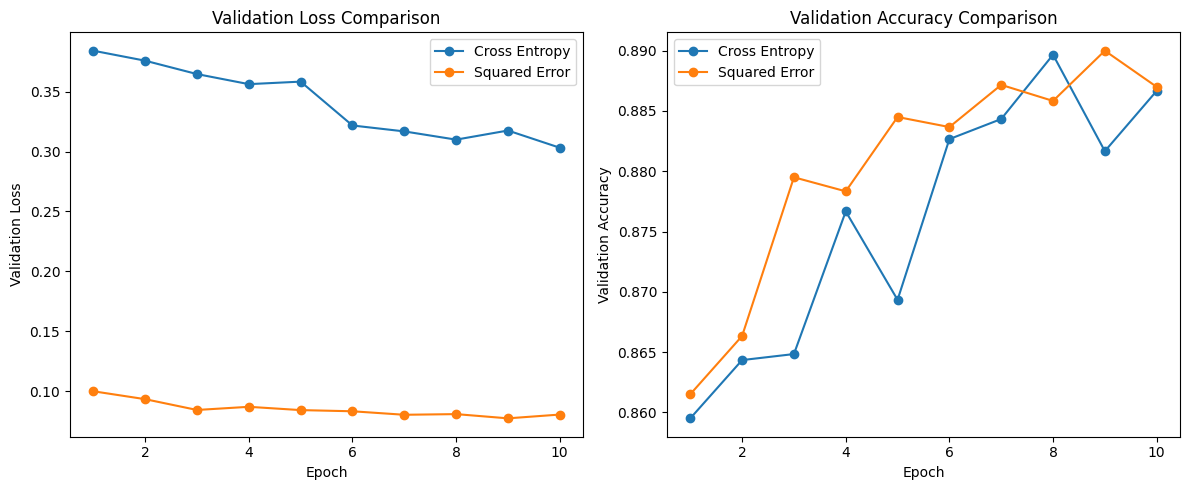

In [13]:
# wandb run for the comparison plot
wandb.init(project="DLasignment1", name="Comparison_Plot", reinit=True)

epochs = np.arange(1, num_epochs+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Validation Loss Comparison
ax1.plot(epochs, val_losses_ce, marker='o', label="Cross Entropy")
ax1.plot(epochs, val_losses_se, marker='o', label="Squared Error")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# Plot Validation Accuracy Comparison
ax2.plot(epochs, val_acc_ce, marker='o', label="Cross Entropy")
ax2.plot(epochs, val_acc_se, marker='o', label="Squared Error")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()

# Log the comparison plot to wandb
wandb.log({"comparison_plot": wandb.Image(fig)})
wandb.finish()

# Q10

In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix

# Load MNIST dataset (handwritten digits)
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Split off 10% of training data as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# Flatten images and normalize to [0, 1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# One-hot encode training and validation labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
# For evaluation, we keep y_test as integers.


2025-03-09 15:14:21.973647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 15:14:21.974402: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 15:14:21.978500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 15:14:21.989555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741513462.008640  112193 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741513462.01

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
import math

def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLPWithLoss:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0, loss_type='cross_entropy'):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        self.loss_type = loss_type
        
        # Set activation function and derivative
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")
        
        # Build network architecture: input -> hidden layers -> output
        layer_dims = [input_dim] + [hidden_size] * num_hidden_layers + [output_dim]
        self.weights = []
        self.biases = []
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                W = np.random.randn(fan_in, fan_out) * 0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []  # store pre-activations
        self.activations = [X]
        A = X
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        if self.loss_type == 'cross_entropy':
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        else:
            raise ValueError("This class supports only cross_entropy for this experiment.")
        # Add L2 regularization
        if self.weight_decay > 0:
            for W in self.weights:
                loss += (self.weight_decay / (2*m)) * np.sum(W**2)
        return loss
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        # For cross-entropy with softmax, gradient is (y_pred - y_true)/m
        delta = (y_pred - y_true) / m
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer gradients
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # Add L2 gradient
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db

# Adam optimizer from previous experiments
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


In [3]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    # Create model with the specified loss type (for MNIST we use cross_entropy)
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    # Initialize wandb run for this experiment
    wandb.init(project="DL_Assignment1", reinit=True, config={
        "loss_type": loss_type,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        **model_params
    })
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics for this epoch to wandb
        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    wandb.finish()
    return model, train_losses, val_losses, val_accuracies


In [4]:
# Configuration 1
print("Running Configuration 1 (Balanced Complexity)")
model_params1 = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}
model1, train_losses1, val_losses1, val_acc1 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=64,
    learning_rate=1e-3,
    model_params=model_params1,
    optimizer_class=Adam
)

# Configuration 2
print("\nRunning Configuration 2 (Simpler Model)")
model_params2 = {
    "num_hidden_layers": 3,
    "hidden_size": 64,
    "output_dim": 10,
    "weight_init": "random",
    "activation": "relu",
    "weight_decay": 0.0
}
model2, train_losses2, val_losses2, val_acc2 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=32,
    learning_rate=1e-3,
    model_params=model_params2,
    optimizer_class=Adam
)

# Configuration 3
print("\nRunning Configuration 3 (Deeper Network with Lower LR)")
model_params3 = {
    "num_hidden_layers": 5,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}
model3, train_losses3, val_losses3, val_acc3 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=64,
    learning_rate=1e-4,
    model_params=model_params3,
    optimizer_class=Adam
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Running Configuration 1 (Balanced Complexity)


wandb: Currently logged in as: ma23m020 (snehalma23m020-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.2776 | Val Loss: 0.1267 | Val Acc: 0.9622
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.1142 | Val Loss: 0.0986 | Val Acc: 0.9722
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.0796 | Val Loss: 0.0962 | Val Acc: 0.9708
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.0661 | Val Loss: 0.0815 | Val Acc: 0.9778
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.0533 | Val Loss: 0.0819 | Val Acc: 0.9767
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.0478 | Val Loss: 0.0828 | Val Acc: 0.9777
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0393 | Val Loss: 0.0841 | Val Acc: 0.9778
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0371 | Val Loss: 0.0997 | Val Acc: 0.9747
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0345 | Val Loss: 0.0920 | Val Acc: 0.9758
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0296 | Val Loss: 0.1001 | Val Acc: 0.9780


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▅█▇██▇▇█
val_loss,█▄▃▁▁▁▁▄▃▄
epoch,10
train_loss,0.02961
val_accuracy,0.978
val_loss,0.10007



Running Configuration 2 (Simpler Model)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.7100 | Val Loss: 0.3379 | Val Acc: 0.9078
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.2743 | Val Loss: 0.2171 | Val Acc: 0.9365
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.1811 | Val Loss: 0.1647 | Val Acc: 0.9508
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.1379 | Val Loss: 0.1366 | Val Acc: 0.9602
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.1098 | Val Loss: 0.1296 | Val Acc: 0.9618
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.0938 | Val Loss: 0.1126 | Val Acc: 0.9677
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0794 | Val Loss: 0.1218 | Val Acc: 0.9677
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0693 | Val Loss: 0.1156 | Val Acc: 0.9668
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0599 | Val Loss: 0.1445 | Val Acc: 0.9642
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0551 | Val Loss: 0.1464 | Val Acc: 0.9592


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇████▇
val_loss,█▄▃▂▂▁▁▁▂▂
epoch,10
train_loss,0.05514
val_accuracy,0.95917
val_loss,0.14639



Running Configuration 3 (Deeper Network with Lower LR)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.6117 | Val Loss: 0.2627 | Val Acc: 0.9235
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.2315 | Val Loss: 0.1843 | Val Acc: 0.9452
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.1760 | Val Loss: 0.1480 | Val Acc: 0.9573
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.1443 | Val Loss: 0.1289 | Val Acc: 0.9642
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.1218 | Val Loss: 0.1283 | Val Acc: 0.9613
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.1047 | Val Loss: 0.1066 | Val Acc: 0.9687
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0905 | Val Loss: 0.0998 | Val Acc: 0.9677
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0795 | Val Loss: 0.0995 | Val Acc: 0.9692
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0708 | Val Loss: 0.0901 | Val Acc: 0.9733
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0624 | Val Loss: 0.0888 | Val Acc: 0.9725


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▆▇▇▇██
val_loss,█▅▃▃▃▂▁▁▁▁
epoch,10
train_loss,0.06242
val_accuracy,0.9725
val_loss,0.08883


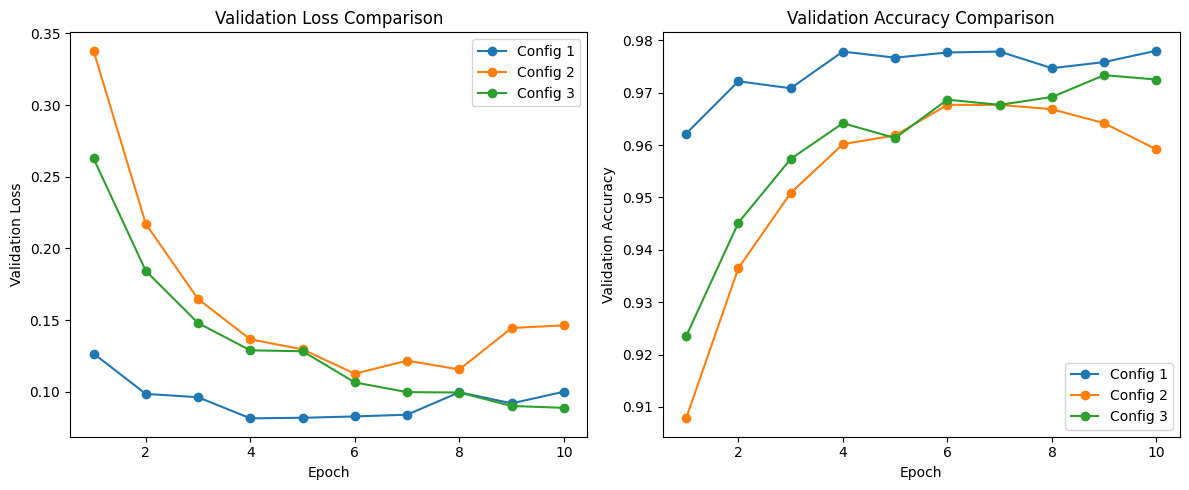

Final Validation Accuracies:
Configuration 1: 97.80%
Configuration 2: 95.92%
Configuration 3: 97.25%


<Figure size 640x480 with 0 Axes>

In [5]:
wandb.init(project="DLassignment1", name="Ques10", reinit=True)

epochs = np.arange(1, 11)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Validation Loss Comparison
ax1.plot(epochs, val_losses1, marker='o', label="Config 1")
ax1.plot(epochs, val_losses2, marker='o', label="Config 2")
ax1.plot(epochs, val_losses3, marker='o', label="Config 3")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# Plot Validation Accuracy Comparison
ax2.plot(epochs, val_acc1, marker='o', label="Config 1")
ax2.plot(epochs, val_acc2, marker='o', label="Config 2")
ax2.plot(epochs, val_acc3, marker='o', label="Config 3")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()

wandb.log({"mnist_comparison_plot": wandb.Image(plt.gcf())})
wandb.finish()

# Print final validation accuracies (as proxy for test accuracy)
print("Final Validation Accuracies:")
print(f"Configuration 1: {val_acc1[-1]*100:.2f}%")
print(f"Configuration 2: {val_acc2[-1]*100:.2f}%")
print(f"Configuration 3: {val_acc3[-1]*100:.2f}%")
